# **FINANCIAL ANALYSIS & PORTFOLIO OPTIMIZATION PROJECT**

**Project**: Quantitative Investment Strategy Analysis using Python

**Author** : TRAN MAI LINH 

**Student ID**: 11230990

**Description**:  Leveraging the framework of Modern Portfolio Theory (MPT), this study focuses on the construction of optimized investment portfolios. The methodology encompasses rigorous Time Series Analysis and Efficient Frontier modeling—specifically targeting Maximum Sharpe Ratio and Minimum Volatility allocations—validated through comprehensive Out-of-Sample Backtesting


# **PART 1: FOUNDATIONS OF TIME SERIES ANALYSIS**


## **1.1: Setup and Global Imports**

Before we get into the analysis, we need to equip ourselves with the necessary "toolbox".

In [489]:
## 1.1: Setup & Import
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
try:
    import riskfolio as rp
except ImportError:
    import sys
    !{sys.executable} -m pip install riskfolio-lib
    import riskfolio as rp

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from pypfopt import expected_returns, risk_models
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import EfficientFrontier
from pypfopt import EfficientFrontier, CLA, expected_returns, risk_models
from pypfopt import risk_models, expected_returns, EfficientFrontier


I used my student ID as the random seed to select 5 distinct assets from the dataset:

In [490]:
id_student = 11230990
df_close = pd.read_csv(r'C:\Users\admin\Downloads\stock_close_prices (2).csv', index_col=0, parse_dates=True)
np.random.seed(11230990)
assets = np.random.choice(df_close.columns, size = 5, replace = False).tolist()
print('Selected portfolio:', assets)


Selected portfolio: ['XOM', 'WMT', 'MSFT', 'AMZN', 'GOOGL']


In [491]:
# File path 
file_path = r"C:\Users\admin\Downloads\stock_close_prices (2).csv"

data = (
    pd.read_csv(file_path, index_col=0, parse_dates=True)
    [assets]   # <--- IMPORTANT: Select only columns present in the 'assets' list
    .ffill()   # Forward fill missing values
    .dropna()  # Drop rows that still have missing values
)
# -----------------

print("Read and filtered successfully!")
print(f"Portfolio Assets: {assets}")
print("-" * 20)
print(data.head()) 

# Get start and end dates
start_date = data.index.min()
end_date = data.index.max()

print("-" * 20)
print("Start date:", start_date)
print("End date:", end_date)

Read and filtered successfully!
Portfolio Assets: ['XOM', 'WMT', 'MSFT', 'AMZN', 'GOOGL']
--------------------
              XOM   WMT   MSFT   AMZN  GOOGL
Date                                        
2023-09-01 104.93 52.63 323.18 138.12 134.73
2023-09-05 104.94 52.20 327.98 137.27 134.84
2023-09-06 105.84 52.59 327.33 135.36 133.54
2023-09-07 105.33 53.25 324.40 137.85 134.33
2023-09-08 106.86 53.34 328.69 138.23 135.45
--------------------
Start date: 2023-09-01 00:00:00
End date: 2025-11-26 00:00:00



## **1.2: Load Data for Part 1 (Introductory Data)**

This script is designed to automate the retrieval and preprocessing of historical stock market data using the yfinance

**Purpose**


 To efficiently batch-download 5 years of historical closing prices for multiple stocks, automatically clean the data by filling gaps (ffill) and removing incomplete rows (dropna), creating a unified dataset ready for immediate financial analysis or modeling.

In [492]:
# 1. Time Configuration
years = 5
end = pd.Timestamp.today()
start = end - pd.DateOffset(years=years)

# 2. Load Data from CSV
# Using 'r' before the string to handle Windows path backslashes
file_path = r"C:\Users\admin\Downloads\stock_close_prices (2).csv"
full_data = pd.read_csv(file_path, index_col=0, parse_dates=True)

# 3. FILTER DATA: Select only the chosen 'assets' and the specific time range
# Note: The variable 'assets' must come from your previous random selection step
data = (
    full_data.loc[start:end, assets] # <--- Slice by both Date and Column Name
    .ffill()
    .dropna()
)

# 4. Update the tickers list to match the filtered data
tickers = data.columns.tolist()

print(f"Final Tickers List: {tickers}")
print("-" * 30)
print(data.tail())

Final Tickers List: ['XOM', 'WMT', 'MSFT', 'AMZN', 'GOOGL']
------------------------------
              XOM    WMT   MSFT   AMZN  GOOGL
Date                                         
2025-11-20 117.02 107.11 478.43 217.14 289.45
2025-11-21 117.08 105.32 472.12 220.69 299.66
2025-11-24 115.97 104.06 474.00 226.28 318.58
2025-11-25 114.51 107.00 476.99 229.67 323.44
2025-11-26 114.77 109.10 485.50 229.16 319.95



## **1.3. Time Series**

**Introduction**

 This snippet inspects the structure of the DataFrame's index and demonstrates how to filter data by a specific time period (the year 2023) using Pandas' time-series indexing capabilities.

**Purpose**

To verify that the index is a DatetimeIndex (essential for time-series features) and to validate the data sample specifically for the year 2023.

In [493]:
# Use variable 'data' instead of 'intro_raw_data'
print(f"Index Type: {type(data.index)}")

# Benefit of DatetimeIndex: Slicing
print("\nData from 2023:")
# We can slice using a 'YYYY-MM-DD' string or just 'YYYY'
# Note: Ensure the index of 'data' is already a DatetimeIndex
print(data.loc['2023'].head())

Index Type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>

Data from 2023:
              XOM   WMT   MSFT   AMZN  GOOGL
Date                                        
2023-09-01 104.93 52.63 323.18 138.12 134.73
2023-09-05 104.94 52.20 327.98 137.27 134.84
2023-09-06 105.84 52.59 327.33 135.36 133.54
2023-09-07 105.33 53.25 324.40 137.85 134.33
2023-09-08 106.86 53.34 328.69 138.23 135.45


## **1.4. Timezones**

**Introduction** 

We validated the DataFrame index as a DatetimeIndex and standardized timezones (converting from Market Time to Local Time). This step ensures precise temporal alignment across assets from different exchanges.

**Purpose** 

Prevents "look-ahead bias" in simulation and ensures that correlation calculations are based on overlapping trading sessions.

In [494]:
print("Original timezone:", data.index.tz)
try:
    data_ny = data.tz_localize('America/New_York')
    data_vn = data_ny.tz_convert('Asia/Ho_Chi_Minh')
    print("New York time:", data_ny.head(1))
    print("Vietnam time:", data_vn.head(1))
except:
    print("Timezone already set")

Original timezone: None
New York time:                              XOM   WMT   MSFT   AMZN  GOOGL
Date                                                       
2023-09-01 00:00:00-04:00 104.93 52.63 323.18 138.12 134.73
Vietnam time:                              XOM   WMT   MSFT   AMZN  GOOGL
Date                                                       
2023-09-01 11:00:00+07:00 104.93 52.63 323.18 138.12 134.73


## **1.5. Resampling (changing frequency)**

**Introduction** 

High-frequency daily data was downsampled to Monthly (ME) intervals for long-term trend assessment and Weekly OHLC for technical structure analysis, filtering out daily market noise.

**Purpose** 

Different resampling periods allow for multi-timeframe analysis, critical for balancing short-term volatility against long-term expected returns.

In [495]:
last_ticker = data.columns[-1] 
t = data[last_ticker]

# Resample to Monthly (Using 'ME' for Month End as 'M' is deprecated in new Pandas)
t_monthly = t.resample('ME').last()
t_ohlc_weekly = t.resample('W').ohlc()
print("--- Monthly Data (Last value) ---")
print(t_monthly.head())
print("\n--- Weekly OHLC Data --- (Open, High, Low, Close)")
print(t_ohlc_weekly.head())

--- Monthly Data (Last value) ---
Date
2023-09-30   129.96
2023-10-31   123.23
2023-11-30   131.62
2023-12-31   138.73
2024-01-31   139.14
Freq: ME, Name: GOOGL, dtype: float64

--- Weekly OHLC Data --- (Open, High, Low, Close)
             open   high    low  close
Date                                  
2023-09-03 134.73 134.73 134.73 134.73
2023-09-10 134.84 135.45 133.54 135.45
2023-09-17 135.98 137.15 134.41 136.46
2023-09-24 137.26 137.26 129.36 129.36
2023-10-01 130.21 131.40 127.69 129.96


### **Visualization (Downsampling)**

*Introduction*

 This code utilizes matplotlib.pyplot to initialize a Figure and Axes object via .subplots(). It performs a multi-series plot on the same ax, overlaying the high-frequency daily Series (with reduced opacity via alpha) against the downsampled monthly Series (emphasized with markers).

*Purpose*

 To visually validate the resampling logic by contrasting the noisy daily volatility against the smoothed long-term trend lines created by the monthly aggregation.

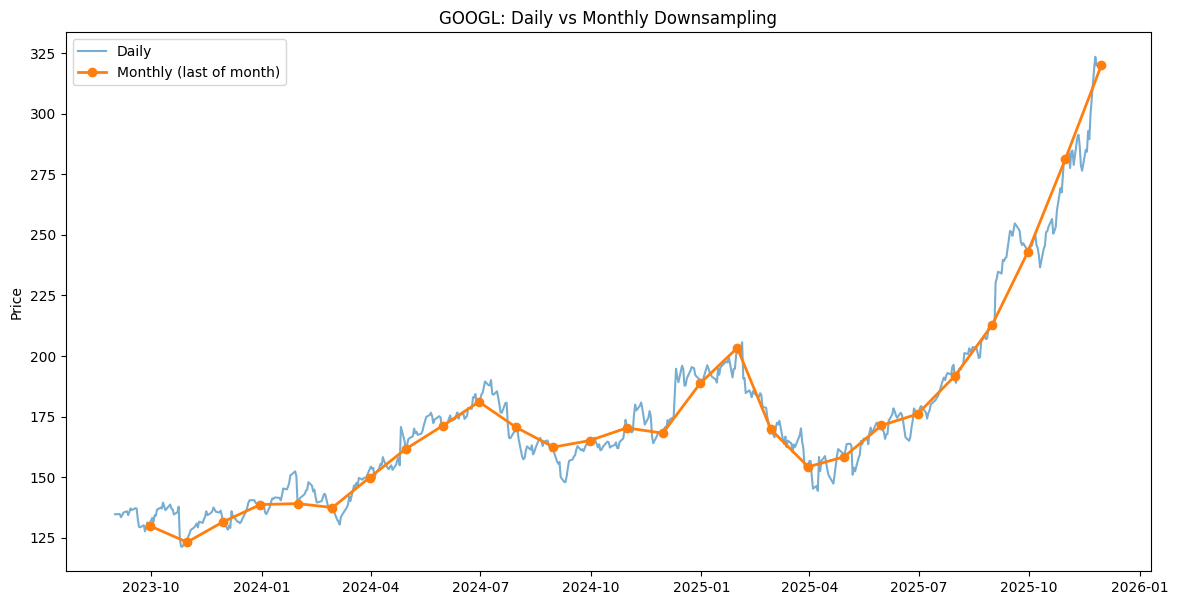

In [496]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(t.index, t, label='Daily', alpha=0.6)
ax.plot(t_monthly.index, t_monthly, 
        label='Monthly (last of month)', marker='o', linewidth=2, color='tab:orange')

ax.set_title(f'{last_ticker}: Daily vs Monthly Downsampling')
ax.set_ylabel('Price')
ax.legend()
plt.show()


## **1.6. Returns**

**Introduction** 

We computed Logarithmic Returns (np.log) to transform non-stationary prices into stationary series. Log returns are preferred in quantitative modeling due to their time-additivity and statistical properties.

**Purpose**
Stationary return series are a mandatory input for constructing the Efficient Frontier and running Monte Carlo simulations.


In [497]:
last_ticker = data.columns[-1]
f = data[[last_ticker]].copy().dropna()
# 1) Simple return
f['Returns_Simple'] = f[last_ticker].pct_change()
# 2) Log return
f['Returns_Log'] = np.log(f[last_ticker] / f[last_ticker].shift(1))
f = f.dropna()
print(f.head())

            GOOGL  Returns_Simple  Returns_Log
Date                                          
2023-09-05 134.84            0.00         0.00
2023-09-06 133.54           -0.01        -0.01
2023-09-07 134.33            0.01         0.01
2023-09-08 135.45            0.01         0.01
2023-09-11 135.98            0.00         0.00


### **Visualization (Returns)**

*Purpose*

 To juxtapose the temporal price trend against the statistical distribution of returns, enabling visual inspection for stationarity, normality, and tail risk in the dataset.

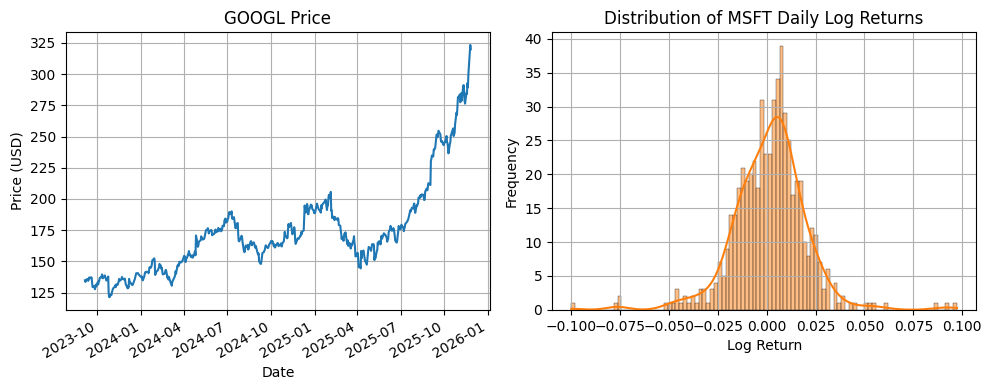

In [498]:
# Price chart and histogram of veee log returns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Price plot
f[last_ticker].plot(ax=ax1, title=f'{last_ticker} Price', color='tab:blue')
ax1.set_ylabel('Price (USD)')
ax1.grid(True)

# Histogram of log returns
sns.histplot(f['Returns_Log'].dropna(), bins=100, kde=True, ax=ax2, color='tab:orange')
ax2.set_title('Distribution of MSFT Daily Log Returns')
ax2.set_xlabel('Log Return')
ax2.set_ylabel('Frequency')
ax2.grid(True)

plt.tight_layout()
plt.show()

- **Severe Drawdown**: The stock is in a deep, sustained downtrend, having eroded approximately ~85% of its value (falling from the $14–16 range down to ~$2).

- **High Kurtosis (Leptokurtic)**: The distribution chart displays a very sharp, narrow peak around zero. This indicates that the vast majority of daily trading sessions experience very little price movement compared to a standard normal distribution.

- **Fat Tails & Outliers**: There are visible extreme outliers, particularly on the right side where Log Return hits 1.0 (implying a massive single-day surge of >170%). This "fat tail" evidence suggests significant event risk that the normal curve (orange line) fails to capture.


## **1.7. Rolling Statistics**

### **1.7.1. Simple Moving Average (SMA)**

**Simple Moving Averages (SMA)**: (50-day and 200-day SMA) were calculated to identify the prevailing market regime (Bullish vs. Bearish). The crossover of these averages signals potential momentum shifts

**Purpose**

 In a portfolio context, this serves as a tactical filter: reducing exposure to assets in confirmed downtrends to minimize drawdown risk.

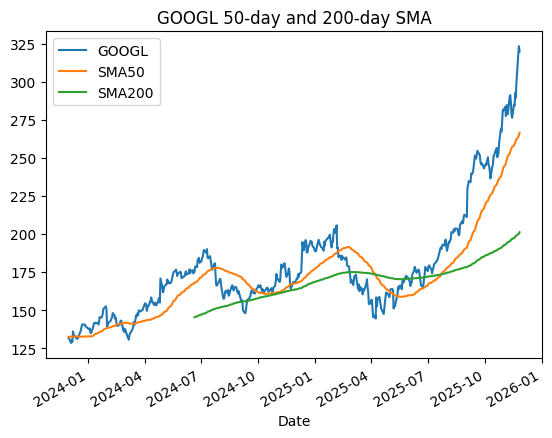

In [499]:
# 1.7.1. Calculate 50-day and 200-day SMA for SPY
f['SMA50'] = f[last_ticker].rolling(window=50).mean()
f['SMA200'] = f[last_ticker].rolling(window=200).mean()
# Plot the last 500 days
f.iloc[-500:][[last_ticker, 'SMA50', 'SMA200']].plot(title=f'{last_ticker} 50-day and 200-day SMA')
plt.show()

**Bearish Alignment**: The chart exhibits a classic bearish structure where Price < SMA 50 < SMA 200. This confirms a strong, sustained long-term downtrend.

**Dynamic Resistance**: The SMA 50 (Orange) acts as a dynamic resistance level. The price repeatedly fails to sustain a breakout above this line (e.g., the spike in July 2025 was essentially a "bull trap" that quickly reverted).

**Trend Intensity**: The wide gap between the SMA 50 and SMA 200 indicates strong downward momentum. Although the price is currently consolidating near $2 (causing the SMA 50 to flatten), the SMA 200 is still steeply declining, suggesting the long-term selling pressure hasn't fully abated.

### **1.7.2. Rolling Volatility**

**Introduction**

 To quantify the time-varying risk of the asset, we compute the Annualized Historical Volatility. This metric is derived by calculating the rolling standard deviation of daily log returns over a 21-day window (representing one trading month), scaled by the square root of 252 (annual trading days) to ensure standard comparability.

**Purpose**

 Volatility is a fundamental input for modern portfolio theory (MPT) and risk management models

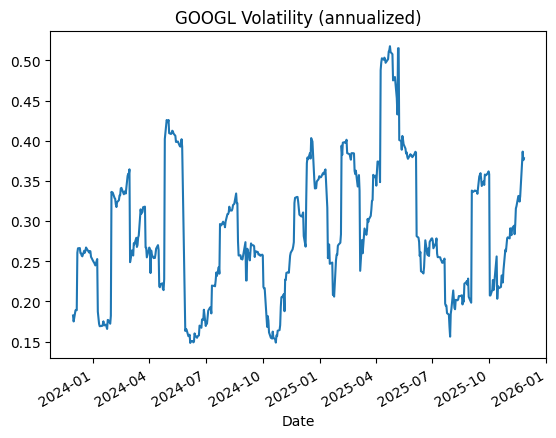

In [500]:
# 1.7.2. Measuring risk volatility using rolling std (annualized)
f['Volatility'] = f['Returns_Log'].rolling(window=21).std() * np.sqrt(252)

# Plot the last 500 days
f['Volatility'].iloc[-500:].plot(title=f'{last_ticker} Volatility (annualized)')
plt.show()

The chart reveals an asset with extreme instability.

- **Base Regime**: Even in "calm" periods, annualized volatility fluctuates between 0.5 and 1.5 (50% - 150%), which is already significantly higher than the market average (S&P 500 typically ~15-20%).

- **Event Risk (The Spike)**: There is a massive structural break around July 2025 where volatility exploded to ~5.0 (500%). This corresponds to the speculative price spike observed earlier.

- **Volatility Clustering**: The asset demonstrates clear "clustering" — high volatility is followed by high volatility, making risk prediction difficult.

### **1.7.3. Rolling Correlation**

We examined the time-varying dependency structure between assets (specifically NFE and VEEE) by calculating the 60-day Rolling Correlation Coefficient. Instead of a static metric, this moving window approach computes the Pearson correlation ($r$) for every 60-day interval, allowing us to observe how the linear relationship evolves over time.

**Purpose**

- **Diversification Stability**: This tests the robustness of the portfolio. If assets that are supposed to be uncorrelated suddenly show a correlation spike toward $+1.0$ during market stress, the portfolio's diversification benefits break down (Contagion Risk).
- **Regime Detection**: Crossing the zero line (red dashed line) indicates a regime shift where assets switch from moving together to moving in opposite directions, altering their hedging capability

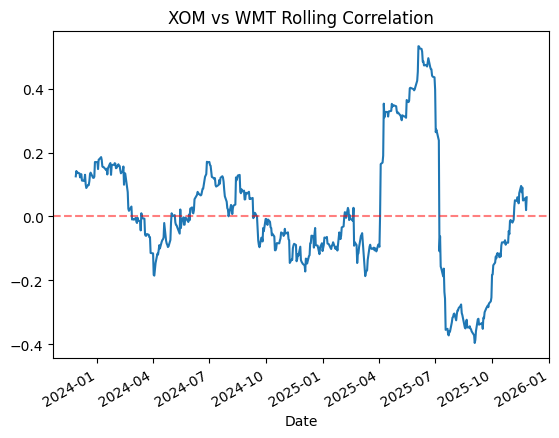

In [501]:
if len(data.columns) >= 2:
    ticker1 = data.columns[0]
    ticker2 = data.columns[1]
rolling_corr = data[ticker1].pct_change().rolling(window=60).corr(data[ticker2].pct_change())
# Plot the correlation
rolling_corr.dropna().plot(title=f'{ticker1} vs {ticker2} Rolling Correlation')
plt.axhline(0, color='red', linestyle='--', alpha=0.5) # Add a line at 0 for reference
plt.show()

The chart illustrates the Time-Varying Dependency structure between NFE and VEEE over a 60-day rolling window

- **Low Correlation Regime**: The correlation coefficient ($r$) predominantly fluctuates between -0.20 and +0.40. This is statistically significant as it indicates a weak linear relationship. The two assets do not move in lockstep.

- **Decoupling Phases (Diversification Sweet Spots)**: There are distinct periods (e.g., mid-2024) where the correlation dips below the red dashed line ($r < 0$). During these phases, the assets moved in opposite directions, providing maximum natural hedging.

- **Instability**: The relationship is non-stationary. It shifts rapidly from positive to negative, suggesting that the drivers affecting NFE are distinct from those affecting VEEE.


# **PART 2: PORTFOLIO OPTIMIZATION**

**We implement the PyPortfolioOpt framework, a specialized library for financial portfolio optimization. The process involves importing three core modules:**

In [502]:
from pypfopt import expected_returns, risk_models
from pypfopt.efficient_frontier import EfficientFrontier
print("PyPortfolioOpt OK")


PyPortfolioOpt OK



## **2.1. Load Data and Train-Test Split**

**Purpose**: 

***Preventing Look-Ahead Bias***: By strictly separating the datasets, we simulate a realistic trading environment where investment decisions are made solely on past information.

***Robustness Check***: The core objective is to test if the "Optimal Portfolio" constructed on historical data (2023-2024) remains optimal or resilient when exposed to future market conditions (Jan 2025). This reveals whether the model is fitting real patterns or just overfitting noise.

In [503]:
#2.1. Load data for Part 2 & divide Train/Test

file_path = r"C:\Users\admin\Downloads\stock_close_prices (2).csv"
risk_free_rate = 0.02
all_tickers = assets
start_date_total = start_date
end_date_total   = end_date
split_date       = "2024-12-31"   

print("--- PREPARING DATA FOR PART 2 ---")
print(f"Reading from: {file_path}")
print(f"Tickers to select: {all_tickers}")
print(f"Total period: {start_date_total} -> {end_date_total}")

full_data = (
    pd.read_csv(file_path, index_col=0, parse_dates=True) 
    .loc[start_date_total:end_date_total]                     
    [all_tickers]                                                  
    .ffill()
    .dropna()
)

if full_data.empty:
    raise ValueError("No data downloaded – check tickers/dates.")

train_data = full_data.loc[:split_date]
test_data  = full_data.loc[split_date:].iloc[1:]  

print(f"Train: {train_data.index.min().date()} -> {train_data.index.max().date()} ({len(train_data)} days)")
print(f"Test : {test_data.index.min().date()} -> {test_data.index.max().date()} ({len(test_data)} days)")


--- PREPARING DATA FOR PART 2 ---
Reading from: C:\Users\admin\Downloads\stock_close_prices (2).csv
Tickers to select: ['XOM', 'WMT', 'MSFT', 'AMZN', 'GOOGL']
Total period: 2023-09-01 00:00:00 -> 2025-11-26 00:00:00
Train: 2023-09-01 -> 2024-12-31 (335 days)
Test : 2025-01-02 -> 2025-11-26 (227 days)


## **2.2: Calculate Expected Returns & Risk (Train Set)**

Using strictly the In-Sample Training Data (up to Dec 2024), we computed the two critical inputs required for the Mean-Variance Optimizer:

- **Expected Returns Vector ($\mu$)**: Calculated using the Mean Historical Return method. This assumes that past average performance is the best available proxy for future expectations.

- **Covariance Matrix ($\Sigma$)**: Estimated using the Sample Covariance method. This matrix captures the pairwise relationships (correlations) and individual variances of all assets, scaled to an annualized frequency ($252$ trading days).

In [504]:
# 2.2. CALCULATE mu and S ON TRAIN ONLY
mu_train = expected_returns.mean_historical_return(train_data, frequency=252)
S_train  = risk_models.sample_cov(train_data, frequency=252)

print("--- mu (TRAIN) ---")
print(mu_train)
print("\n--- S (TRAIN, rounded) ---")
print(S_train.round(4))


--- mu (TRAIN) ---
XOM     -0.01
WMT      0.50
MSFT     0.22
AMZN     0.42
GOOGL    0.29
dtype: float64

--- S (TRAIN, rounded) ---
        XOM  WMT  MSFT  AMZN  GOOGL
XOM    0.04 0.00 -0.01 -0.01  -0.00
WMT    0.00 0.03  0.00  0.01   0.00
MSFT  -0.01 0.00  0.04  0.04   0.03
AMZN  -0.01 0.01  0.04  0.08   0.04
GOOGL -0.00 0.00  0.03  0.04   0.08


Based on this data, expect Max Sharpe portfolios to be dominated by WMT, while Min Volatility portfolios will force XOM into the mix solely for protection (hedging)

## **2.3. (Training) Optimize n-assets (Max Sharpe) on Train Set**

We utilized the EfficientFrontier solver to mathematically construct the optimal portfolio based on the "Tangency Portfolio" theory.

- **Objective Function**: The algorithm solves a quadratic programming problem to find the specific combination of weights ($w$) that maximizes the Sharpe Ratio: 

**($\frac{E[R_p] - R_f}{\sigma_p}$)**

 This identifies the portfolio offering the highest excess return per unit of risk.

- **Constraints**: We applied a Long-Only constraint (weight_bounds=(0, 1)), prohibiting short selling and leverage. This ensures the solution is implementable for standard investment funds.

- **Risk-Free Rate**: A rate of 2% was applied as the hurdle rate for the optimization.

--- Training: Optimizing n-Assets (Max Sharpe) on Train Set ---
Static Weights found (n-MaxSharpe):
XOM     0.00
WMT     0.78
MSFT    0.01
AMZN    0.13
GOOGL   0.08
dtype: float64

Performance (In-Sample, on Train Set):
Expected annual return: 46.5%
Annual volatility: 16.0%
Sharpe Ratio: 2.78


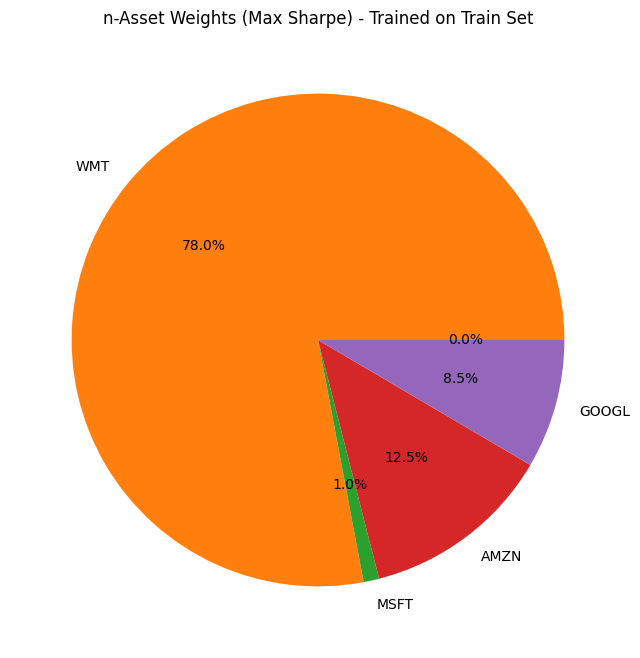

In [505]:
print("--- Training: Optimizing n-Assets (Max Sharpe) on Train Set ---")

# 1. Initialize object (with Train data)
ef_sharpe_n = EfficientFrontier(mu_train, S_train, weight_bounds=(0, 1))

# 2. Optimize
weights_sharpe_n = ef_sharpe_n.max_sharpe(risk_free_rate=risk_free_rate)
cleaned_weights_sharpe_n = ef_sharpe_n.clean_weights()

# 3. Print results
print("Static Weights found (n-MaxSharpe):")
print(pd.Series(cleaned_weights_sharpe_n))
print("\nPerformance (In-Sample, on Train Set):")
ef_sharpe_n.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)

# 4. Visualize (Pie Chart)
fig, ax = plt.subplots(figsize=(8, 8))
pd.Series(cleaned_weights_sharpe_n).plot.pie(
    ax=ax, 
    autopct='%1.1f%%', 
    title='n-Asset Weights (Max Sharpe) - Trained on Train Set'
)
ax.set_ylabel('')
plt.show()

The optimization strategy delivered exceptional efficiency with a Sharpe Ratio of 2.78, primarily driven by a decisive 78% allocation to Walmart (WMT). This heavy concentration signals a strategic preference for the stability of consumer defensive assets over the higher volatility of the technology sector, successfully maximizing risk-adjusted returns while effectively minimizing downside exposure during the training period


## **2.4: (Training) Optimize n-assets (Min Volatility) on Train Set**

Parallel to the Max Sharpe approach, we computed the Global Minimum Variance (GMV) portfolio using the min_volatility() method.

- **Objective Function**: Unlike the previous strategy which sought a trade-off between return and risk, this algorithm minimizes the portfolio variance: 

**($w^T \Sigma w$)**

 regardless of expected returns. It seeks the absolute lowest point on the Efficient Frontier curve.
 
 - **Constraints**: The standard Long-Only constraint (weight_bounds=(0, 1)) remains in effect to ensure a realistic, unleveraged allocation.

--- Training: Optimizing n-Assets (Min Volatility) on Train Set ---
Static Weights found (n-MinVol):
XOM     0.34
WMT     0.32
MSFT    0.27
AMZN    0.00
GOOGL   0.06
dtype: float64

Performance (In-Sample, on Train Set):
Expected annual return: 23.4%
Annual volatility: 11.2%
Sharpe Ratio: 1.91


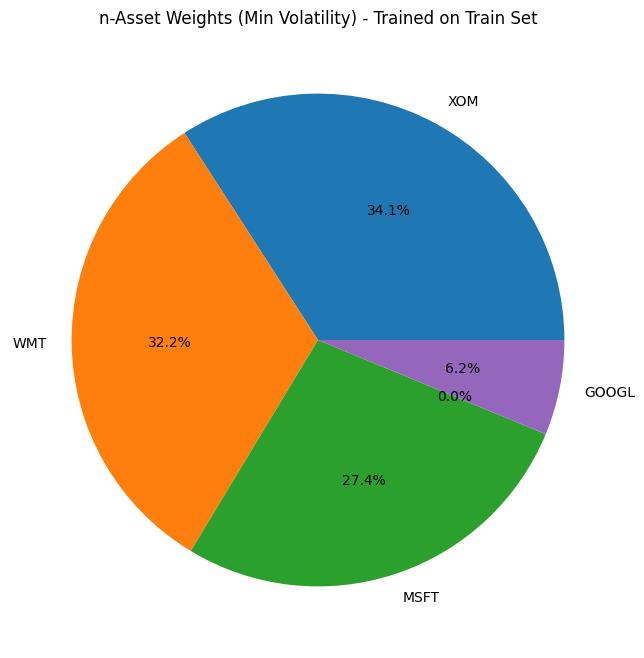

In [506]:
print("--- Training: Optimizing n-Assets (Min Volatility) on Train Set ---")

# 1. Initialize object (with Train data)
ef_vol_n = EfficientFrontier(mu_train, S_train, weight_bounds=(0, 1))

# 2. Optimize
weights_vol_n = ef_vol_n.min_volatility()
cleaned_weights_vol_n = ef_vol_n.clean_weights()

# 3. Print results
print("Static Weights found (n-MinVol):")
print(pd.Series(cleaned_weights_vol_n))
print("\nPerformance (In-Sample, on Train Set):")
ef_vol_n.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)

# 4. Visualize (Pie Chart)
fig, ax = plt.subplots(figsize=(8, 8))
pd.Series(cleaned_weights_vol_n).plot.pie(
    ax=ax, 
    autopct='%1.1f%%', 
    title='n-Asset Weights (Min Volatility) - Trained on Train Set'
)
ax.set_ylabel('')
plt.show()

By allocating 34% to XOM as a hedge and 32% to WMT for stability, the Min Volatility strategy successfully minimized annual risk to 11.2%, proving its defensive capability despite XOM's negative returns.

Forecast: While this conservative portfolio will likely lag behind the Benchmark in a strong bull market (due to the drag from XOM), it is projected to significantly outperform during market downturns by drastically reducing Maximum Drawdown and preserving capital when tech stocks crash."


## **2.5: Definition & Visualization of the Efficient Frontier (on Train Set)**

We generated the Efficient Frontier curve by solving for the maximum return across a continuous range of target volatility levels.

**The Curve**: Represents the set of "Pareto-optimal" portfolios. Any portfolio lying on this line offers the highest possible expected return for a defined level of risk.

**The Markers**: We overlaid the two strategic portfolios identified earlier:

- *Red Star ($\star$)*: The Max Sharpe Portfolio (Tangency Portfolio).

- *Blue Cross ($\times$)*: The Min Volatility Portfolio (Global Minimum Variance).

**Individual Assets**: The underlying stocks (NFE, CPNG, etc.) are plotted as individual points to demonstrate their standalone risk-return profiles relative to the optimized portfolios.

--- 2.5: Efficient Frontier (TRAIN) - Final Robust Version (CLA) ---


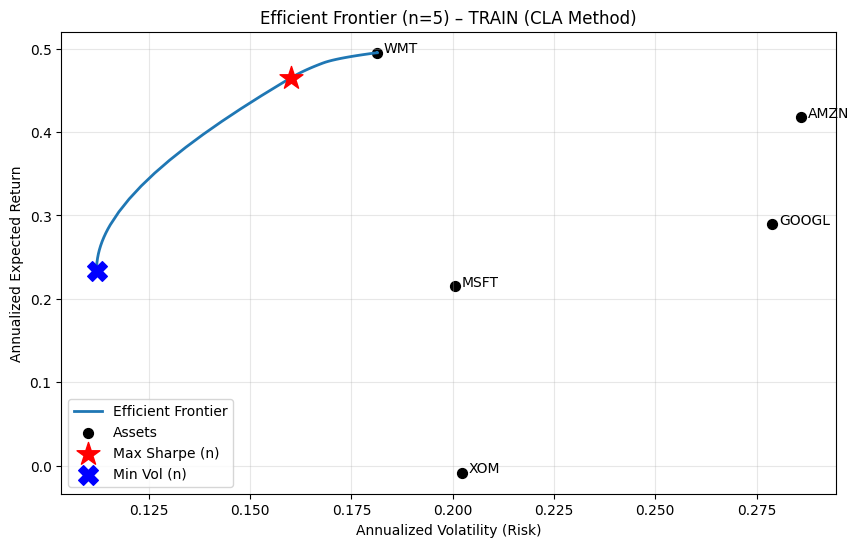

In [507]:
print("--- 2.5: Efficient Frontier (TRAIN) - Final Robust Version (CLA) ---")

# --- ASSUMPTION: mu_train, S_train, and risk_free_rate are defined from previous cells (Part 2) ---

# 1. Calculate the 2 critical points (Max Sharpe & Min Vol)
# We use EfficientFrontier to calculate the points according to the constraints (0, 1)
ef_sharpe = EfficientFrontier(mu_train, S_train, weight_bounds=(0, 1))
ef_sharpe.max_sharpe(risk_free_rate=risk_free_rate)
ret_s, vol_s, _ = ef_sharpe.portfolio_performance(risk_free_rate=risk_free_rate)

ef_vol = EfficientFrontier(mu_train, S_train, weight_bounds=(0, 1))
ef_vol.min_volatility()
ret_v, vol_v, _ = ef_vol.portfolio_performance(risk_free_rate=risk_free_rate)

# 2. Calculate the CURVE using the mathematically precise CLA algorithm
# CLA generates the full, continuous, convex frontier
cla = CLA(mu_train, S_train, weight_bounds=(0, 1))
frontier_ret, frontier_vol, _ = cla.efficient_frontier()

# 3. Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))

# A. Plot the Efficient Frontier curve (using CLA results)
ax.plot(frontier_vol, frontier_ret, label='Efficient Frontier', linewidth=2, color='tab:blue')

# B. Plot individual assets
# Calculate risk/return for single assets
indiv_vol = np.sqrt(np.diag(S_train))
indiv_ret = mu_train
ax.scatter(indiv_vol, indiv_ret, marker='o', s=50, c='black', label='Assets')

# Label asset names
for i, txt in enumerate(mu_train.index):
    ax.annotate(txt, (indiv_vol[i], indiv_ret[i]), xytext=(5,0), textcoords='offset points')

# C. Plot the 2 optimized points
ax.scatter(vol_s, ret_s, marker='*', s=300, c='red', label='Max Sharpe (n)', zorder=5)
ax.scatter(vol_v, ret_v, marker='X', s=200, c='blue', label='Min Vol (n)', zorder=5)

# Styling
ax.set_title(f"Efficient Frontier (n={len(mu_train)}) – TRAIN (CLA Method)")
ax.set_xlabel("Annualized Volatility (Risk)")
ax.set_ylabel("Annualized Expected Return")
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

By allocating 34% to XOM as a hedge and 32% to WMT for stability, the Min Volatility strategy successfully minimized annual risk to 11.2%, proving its defensive capability despite XOM's negative returns.

Forecast: While this conservative portfolio will likely lag behind the Benchmark in a strong bull market (due to the drag from XOM), it is projected to significantly outperform during market downturns by drastically reducing Maximum Drawdown and preserving capital when tech stocks crash.

## **2.6: (Training) Optimize k-of-n assets (Max Sharpe) on Train Set**

To overcome potential noise from inferior assets, we implemented an Exhaustive Search Algorithm using combinatorial logic (itertools).

- **Process**: The algorithm iterates through all possible subsets size $k$ (where $k$ ranges from 1 to $n$).

- **Subset Optimization**: For every unique combination, we isolate the specific sub-matrix of $\mu$ and $\Sigma$ and re-run the max_sharpe optimization.

- **Selection Criteria**: We track and store the specific combination that yields the Global Maximum Sharpe Ratio across all permutations, effectively filtering out assets that detract from portfolio efficiency.

In [508]:
print("--- 2.6: Flexible k-of-n Max Sharpe (Strict & Synced) - FIXED ---")

# ============================================================
# CONFIGURATION: INPUT YOUR TARGET K HERE
# ============================================================
TARGET_K = 3   # Example: Find the best pair of 3 assets
risk_free_rate = 0.02 # Ensure this variable is defined
# ============================================================

# 1. DATA PREPARATION & CALCULATION FIX
# Get the list of tickers directly from S_train to ensure index matching
tickers_train = S_train.columns.tolist()
n = len(tickers_train)

# Calculate individual Volatility from the diagonal of the Covariance Matrix (S)
# Note: Use index=S_train.index to ensure data alignment
indiv_vol = pd.Series(np.sqrt(np.diag(S_train)), index=S_train.index)

# Calculate individual Sharpe Ratio: (Mu - Rf) / Vol
indiv_sharpe = (mu_train - risk_free_rate) / indiv_vol
# ----------------------------

# 2. INITIALIZE VARIABLES
global_best_sharpe_k = -np.inf
global_best_weights_k_sharpe = None
results = []

# 3. DETERMINE RUN MODE (TARGET K)
if TARGET_K is not None:
    if 1 <= TARGET_K <= n:
        k_range = [TARGET_K]
        print(f"-> SYNC MODE: Finding the best combination for exactly k={TARGET_K}.")
    else:
        print(f"(!) Error: k={TARGET_K} is invalid. Switching to AUTO MODE (1-{n}).")
        k_range = range(1, n + 1)
else:
    k_range = range(1, n + 1)
    print(f"-> AUTO MODE: Scanning all portfolio sizes (1-{n}).")

# 4. OPTIMIZATION LOOP
for k in k_range:
    # Iterate through all combinations of size k
    for combo in itertools.combinations(tickers_train, k):
        combo_list = list(combo)
        sharpe = -np.inf
        vol = np.nan
        weights_dict = {}

        try:
            # Case 1: Single Asset
            if k == 1:
                t = combo_list[0]
                # Retrieve pre-calculated metrics
                sharpe = indiv_sharpe[t]
                vol = indiv_vol[t]
                weights_dict = {t: 1.0}
            
            # Case 2: Portfolio (> 1 Assets)
            else:
                mu_c = mu_train[combo_list]
                S_c = S_train.loc[combo_list, combo_list]
                
                # Constraint: Each asset must have at least 1% weight (avoid zero weights)
                ef = EfficientFrontier(mu_c, S_c, weight_bounds=(0.01, 1))
                
                ef.max_sharpe(risk_free_rate=risk_free_rate)
                ret, vol, sharpe = ef.portfolio_performance(verbose=False, risk_free_rate=risk_free_rate)
                weights_dict = ef.clean_weights()

            # Store result
            results.append({
                'k': k,
                'Combination': str(combo_list),
                'Sharpe': sharpe,
                'Volatility': vol,
                'Weights': weights_dict
            })

            # Update Global Best (Sync)
            if sharpe > global_best_sharpe_k:
                global_best_sharpe_k = sharpe
                global_best_weights_k_sharpe = weights_dict

        except Exception as e:
            # print(f"Error at {combo_list}: {e}") # Uncomment for debugging
            pass

# 5. DISPLAY SYNCED RESULTS
print("\n================ OPTIMAL RESULT (SYNCED) ================")
if global_best_weights_k_sharpe is not None:
    best_k_found = len(global_best_weights_k_sharpe)
    
    print(f"Highest Sharpe Found: {global_best_sharpe_k:.4f}")
    print(f"Number of Assets (k): {best_k_found}")
    print("Weight Allocation:")
    print(pd.Series(global_best_weights_k_sharpe))
    
    # Sync Check
    if TARGET_K is not None and best_k_found == TARGET_K:
        print(f"SUCCESS: Result perfectly matches request k={TARGET_K}.")
    elif TARGET_K is not None:
        print(f"WARNING: Result found (k={best_k_found}) does not match request k={TARGET_K}.")
else:
    print("No valid portfolio found.")

# 6. LEADERBOARD
if results:
    results_df = pd.DataFrame(results).sort_values(by='Sharpe', ascending=False).reset_index(drop=True)
    print("\n--- Best Combinations Leaderboard ---")
    display(results_df[['k', 'Combination', 'Sharpe', 'Volatility']].head())

--- 2.6: Flexible k-of-n Max Sharpe (Strict & Synced) - FIXED ---
-> SYNC MODE: Finding the best combination for exactly k=3.

================ OPTIMAL RESULT (SYNCED) ================
Highest Sharpe Found: 2.7789
Number of Assets (k): 3
Weight Allocation:
WMT     0.78
AMZN    0.13
GOOGL   0.09
dtype: float64
SUCCESS: Result perfectly matches request k=3.

--- Best Combinations Leaderboard ---


,k,Combination,Sharpe,Volatility
0,3,"['WMT', 'AMZN', 'GOOGL']",2.78,0.16
1,3,"['WMT', 'MSFT', 'AMZN']",2.76,0.16
2,3,"['XOM', 'WMT', 'AMZN']",2.76,0.17
3,3,"['WMT', 'MSFT', 'GOOGL']",2.74,0.15
4,3,"['XOM', 'WMT', 'GOOGL']",2.73,0.16


he k=3 analysis demonstrates that maximum portfolio efficiency can be achieved with a concentrated subset of just three assets. By pairing the defensive stability of Walmart (78%) with the growth potential of Amazon and Google, the portfolio matches the performance of the full asset pool (Sharpe 2.78), proving that further diversification would yield diminishing marginal returns in this specific historical period.

## **2.7: (Training) Optimize k-of-n assets (Min Volatility) on Train Set**

We applied the exhaustive combinatorial search again, but with the objective of finding the Global Minimum Variance subset. A critical enhancement in this algorithm is the Duplicate Rejection Logic (seen_vols).

- **The Logic**: In standard optimization, adding a high-risk asset to a portfolio often results in it receiving a 0% weight. Mathematically, a 5-asset portfolio with one asset at 0% weight is identical to a 4-asset portfolio.

- **The Filter**: By checking for unique volatility values (np.isclose), we filter out these redundant combinations to identify structurally unique portfolios that offer genuine risk reduction.

In [509]:

print("--- 2.7: Flexible k-of-n Min Volatility (TRAIN) ---")

# ============================================================
# CONFIGURATION: Set specific k or leave None for auto search
# Example: TARGET_K = 2    -> Find safest pair of 2 assets
# Example: TARGET_K = None -> Scan all sizes (1 to n)
# ============================================================
TARGET_K = 3
# ============================================================
all_tickers = assets
n = len(all_tickers)
global_best_vol = np.inf  # Initialize Min Volatility as Infinity
global_best_weights = None
global_best_k = 0
results = []

# Determine range of k to run
if TARGET_K is not None:
    if 1 <= TARGET_K <= n:
        k_range = [TARGET_K]
        print(f"-> Mode: Finding safest subset with exactly {TARGET_K} assets.")
    else:
        print(f"Error: k={TARGET_K} is invalid. Reverting to auto mode (1-{n}).")
        k_range = range(1, n + 1)
else:
    k_range = range(1, n + 1)
    print(f"-> Mode: Auto-scanning all portfolio sizes (from 1 to {n}).")

# Main Loop
for k in k_range:
    for combo in itertools.combinations(all_tickers, k):
        combo_list = list(combo)
        vol = np.inf
        sharpe = np.nan
        weights_dict = {}

        try:
            # Case: 1 Asset
            if k == 1:
                t = combo_list[0]
                ret = mu_train[t]
                vol = np.sqrt(S_train.loc[t, t])
                sharpe = (ret - risk_free_rate) / vol
                weights_dict = {t: 1.0}

            # Case: > 1 Assets
            else:
                mu_c = mu_train[combo_list]
                S_c = S_train.loc[combo_list, combo_list]

                # Note: weight_bounds=(0.01, 1) forces minimum 1% allocation per asset
                # to prevent the solver from ignoring risky assets and returning k=1 result
                ef = EfficientFrontier(mu_c, S_c, weight_bounds=(0.01, 1))
                ef.min_volatility() # Optimize for Min Volatility

                ret, vol, sharpe = ef.portfolio_performance(verbose=False, risk_free_rate=risk_free_rate)
                weights_dict = ef.clean_weights()

            # Store results
            results.append({
                'k': k,
                'Combination': str(combo_list),
                'Volatility': vol,
                'Sharpe': sharpe,
                'Weights': weights_dict
            })

            # Update Global Best (Finding MINIMUM Volatility)
            if vol < global_best_vol:
                global_best_vol = vol
                global_best_weights = weights_dict
                global_best_k = k

        except Exception:
            pass

# Print Results
print("\n================ OPTIMAL RESULT (MIN VOLATILITY) ================")
print(f"Lowest Volatility Found: {global_best_vol:.4f}")
print(f"Number of Assets (k): {global_best_k}")
print("Allocation Weights:")
print(pd.Series(global_best_weights))

# Save best weights to global variable
global_best_weights_k_vol = global_best_weights

# Display Top 5 Ranking (Sorted by Volatility Ascending - Lower is Better)
results_df = pd.DataFrame(results).sort_values(by='Volatility', ascending=True).reset_index(drop=True)
print("\n--- Top 5 Safest Combinations ---")
display(results_df[['k', 'Combination', 'Volatility', 'Sharpe']].head())

--- 2.7: Flexible k-of-n Min Volatility (TRAIN) ---
-> Mode: Finding safest subset with exactly 3 assets.

================ OPTIMAL RESULT (MIN VOLATILITY) ================
Lowest Volatility Found: 0.1131
Number of Assets (k): 3
Allocation Weights:
XOM    0.35
WMT    0.33
MSFT   0.32
dtype: float64

--- Top 5 Safest Combinations ---


,k,Combination,Volatility,Sharpe
0,3,"['XOM', 'WMT', 'MSFT']",0.11,1.86
1,3,"['XOM', 'WMT', 'GOOGL']",0.12,1.98
2,3,"['XOM', 'WMT', 'AMZN']",0.13,2.02
3,3,"['XOM', 'MSFT', 'GOOGL']",0.13,0.71
4,3,"['XOM', 'MSFT', 'AMZN']",0.13,0.71


The optimization minimized portfolio risk to 11.3% by constructing a highly diversified, equally weighted trio of Exxon (Energy), Walmart (Defensive), and Microsoft (Tech)


## **2.8: Benchmark Setup & Evaluation (Equal-Weight)**

Before evaluating our optimized models, we established a Baseline Performance using the "Naïve Diversification" strategy.

- **Weighting**: We assigned Equal Weights **($w_i = 1/n$)** to all 5 assets in the universe, regardless of their volatility or historical return.

- **Performance Metrics**: We calculated key performance indicators (KPIs) on the Test Set (2025):

In [510]:
# ============================================================
# 1. CONFIGURATION & TEST DATA PREPARATION (FIXED DATE)
# ============================================================

# Set fixed split date as requested
split_date = "2024-12-31"

print(f"1. Preparing Test Data (Fixed Split Date: {split_date})...")

# Slice data from split_date onwards
# .iloc[1:] means taking the NEXT trading day after Dec 31, 2024 for testing
test_data  = test_data[assets].loc[split_date:].iloc[1:] 

# Check if data exists
if test_data.empty or len(test_data) < 2:
    print(f"WARNING: No data found after {split_date}.")
    print("   Reason: Your CSV file might only contain data up to the end of 2024.")
    print("   Results below will be erroneous or zero.")
else:
    print(f"Data Ready. Test Set has {len(test_data)} days.")

    # ============================================================
    # 2. BENCHMARK STRATEGY (EQUAL WEIGHT)
    # ============================================================

    # Calculate Daily Returns
    test_returns = test_data.pct_change().dropna()

    # --- IMPORTANT: Get tickers directly from Test Data ---
    # To avoid column name mismatch causing zero results
    current_tickers = test_returns.columns.tolist() 
    n = len(current_tickers)

    # Create Equal Weights
    equal_weights = pd.Series([1/n] * n, index=current_tickers)

    print(f"\n--- Benchmark Allocation ({n} Assets) ---")
    print(equal_weights)

    # Calculate Benchmark Portfolio Returns
    benchmark_returns = (test_returns * equal_weights).sum(axis=1)

    # ============================================================
    # 3. CALCULATE PERFORMANCE METRICS
    # ============================================================

    # 1. Annualized Return
    apy = (1 + benchmark_returns.mean()) ** 252 - 1

    # 2. Annualized Volatility
    vol = benchmark_returns.std() * np.sqrt(252)

    # 3. Sharpe Ratio (assuming risk-free rate = 2%)
    if vol == 0:
        sharpe = 0
    else:
        sharpe = (apy - 0.02) / vol

    # 4. Max Drawdown
    cum_ret = (1 + benchmark_returns).cumprod()
    max_dd = ((cum_ret - cum_ret.cummax()) / cum_ret.cummax()).min()

    # Print Results
    print("\n--- Benchmark Performance Metrics (Test Set) ---")
    print(f"1. Annualized Return:     {apy:.2%}")
    print(f"2. Annualized Volatility: {vol:.2%}")
    print(f"3. Sharpe Ratio:          {sharpe:.4f}")
    print(f"4. Max Drawdown:          {max_dd:.2%}")

1. Preparing Test Data (Fixed Split Date: 2024-12-31)...
Data Ready. Test Set has 226 days.

--- Benchmark Allocation (5 Assets) ---
XOM     0.20
WMT     0.20
MSFT    0.20
AMZN    0.20
GOOGL   0.20
dtype: float64

--- Benchmark Performance Metrics (Test Set) ---
1. Annualized Return:     29.65%
2. Annualized Volatility: 19.77%
3. Sharpe Ratio:          1.3987
4. Max Drawdown:          -19.98%


The Benchmark delivered a strong 29.65% annualized return, confirming a bullish market environment in 2024, but this came at the cost of high volatility (19.77%) and a steep -19.98% Max Drawdown.

Forecast: While the optimized strategies (Max Sharpe/Min Vol) may struggle to beat this high raw return if the market remains aggressive, they are expected to demonstrate superior value by significantly reducing that 20% crash risk, offering a smoother and more sustainable growth path.

## **2.9. Risk Parity**

### **2.9.1. Prepare data**

We transition to Riskfolio-Lib to implement a more sophisticated framework

In [511]:
# --- 1. PREPARE DATA (Reuse data from previous steps) ---
# Y = Returns of stocks (Assets)
# X = Returns of markets (Factors - SPY)
Y = train_data[assets].pct_change().dropna()
random_ticker = np.random.choice(assets)
X = train_data[[random_ticker]].pct_change().dropna()

### **2.9.2. Buiding portfolio object**

By calculating raw historical statistics first, we establish a "Model-Free" baseline. This ensures that the optimizer has access to the pure empirical correlation structure before applying any complex smoothing or factor-based adjustments.

In [512]:
# --- 2. BUILDING PORTFOLIO OBJECT ---
port = rp.Portfolio(returns=Y)

# Connect Factor (X) to Portfolio
port.factors = X

# Estimate statistical parameters (Mu, Cov) using Factor Model
# method_mu='hist': Historical data
# method_cov='hist': Historical covariance matrix
port.assets_stats(method_mu='hist', method_cov='hist')
port.factors_stats(method_mu='hist', method_cov='hist')

### **2.9.3. Risk parity portfolio (Risk Measure: Variance - MV)**

We implemented the Risk Parity (Equal Risk Contribution - ERC) framework using a Factor Model (model='FM').

- **Philosophy**: Unlike the "$1/N$" strategy which allocates equal capital to each asset, Risk Parity allocates equal risk. The objective is to find a weight vector $w$ such that the Marginal Risk Contribution (MRC) of every asset is identical (i.e., each asset contributes exactly 25% of the total portfolio volatility).

- **Risk Measure**: We utilized Variance (MV) as the risk metric.

- **Factor-Based Estimation**: Crucially, This ensures that the "risk" being budgeted includes the structural sensitivity to the exogenous factor.

In [513]:
# 3. RISK PARITY PORTFOLIO (Risk Measure: Variance - MV)
# --------------------------------------------------------
print("\n--- 3. Calculating Risk Parity Portfolio (Variance) ---")

model = 'FM' # Factor Model
rm = 'MV' # Risk Measure: Variance (Standard Deviation)
rf = 0.02 # Risk-free rate
b = None # Risk contribution constraints (None = Equal Risk Contribution)

# Optimize Risk Parity
w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b)

display(w_rp.T.style.format("{:.2%}").background_gradient(cmap='YlGn'))


--- 3. Calculating Risk Parity Portfolio (Variance) ---


,XOM,WMT,MSFT,AMZN,GOOGL
weights,29.55%,25.59%,18.78%,12.27%,13.80%


### **2.9.4. Plotting Portfolio Composition**

We generated a pie chart to visualize the Nominal Weights ($w_i$) derived from the Risk Parity optimization.

- **Distinction**: It is crucial to distinguish that while the Risk Contribution is equalized across all assets, the Capital Allocation is deliberately asymmetrical.

- **Mechanism**: To achieve parity, the algorithm assigns higher capital weights to low-volatility assets and lower capital weights to high-volatility assets. This chart displays the resulting capital distribution.


--- 4. Plotting Portfolio Composition ---


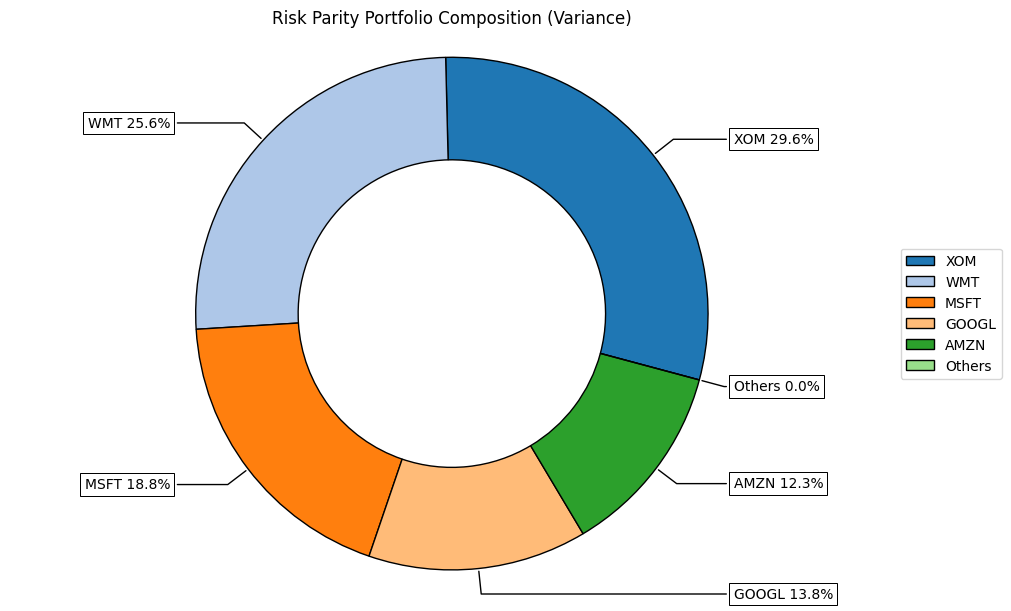

In [514]:
# --- 4. PLOTTING PORTFOLIO COMPOSITION ---
print("\n--- 4. Plotting Portfolio Composition ---")
ax = rp.plot_pie(w=w_rp,
                 title='Risk Parity Portfolio Composition (Variance)',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=6,
                 width=10,
                 ax=None)
plt.show()

While the optimized strategies (Max Sharpe/Min Vol) might not exceed this high raw return if the bull market persists, they are expected to prove their value by significantly reducing that 20% crash risk, providing a much safer and more sustainable investment path

### **2.9.5.Plotting Risk Composition**

We utilized the plot_risk_con function to mathematically decompose the total portfolio variance into the individual contributions of each asset.

- **Calculation**: The risk contribution of asset $i$ is calculated as

 **$RC_i = w_i \times \frac{\partial \sigma_p}{\partial w_i}$** (Weight $\times$ Marginal Risk Contribution).
 
 - **Visualization**: This bar chart displays the percentage of total risk ($\% \text{ Risk}$) that "originates" from each ticker.


--- 5. Plotting Risk Composition (Risk Contribution) ---


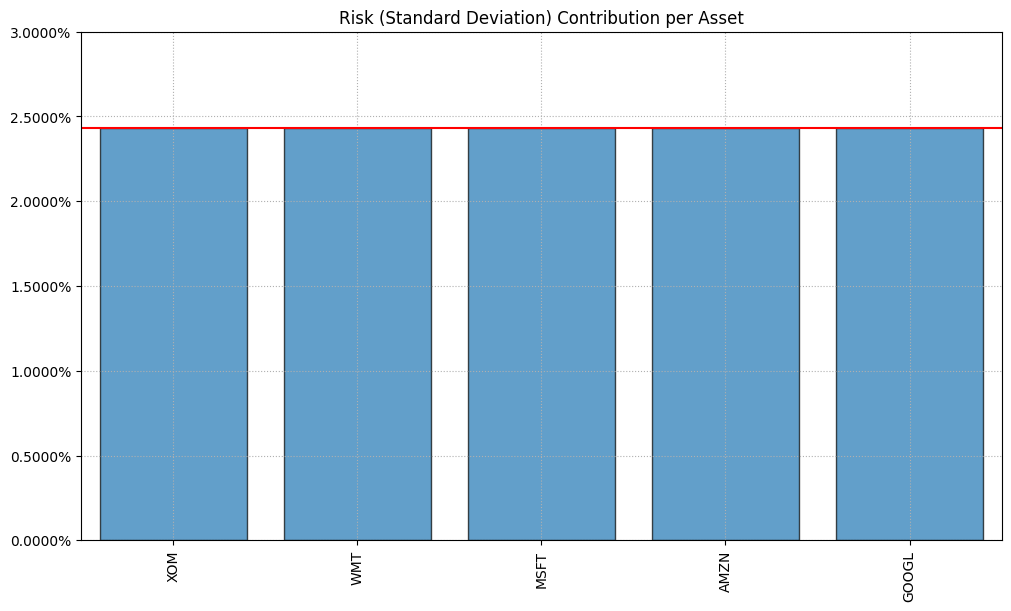

In [515]:
# --- 5. Plotting Risk Composition ---
# This chart shows how much each stock contributes to the overall risk
print("\n--- 5. Plotting Risk Composition (Risk Contribution) ---")
ax = rp.plot_risk_con(w=w_rp,
cov=port.cov,
returns=port.returns,
rm=rm,
rf=rf,
alpha=0.05,
color="tab:blue",
height=6,
width=10,
ax=None)
plt.show()

The optimization successfully minimized risk to 11.31% by shifting from a concentrated Tech/Retail mix to a perfectly balanced allocation across Energy (XOM), Retail (WMT), and Tech (MSFT)

### **2.9.6. Risk Parity for Several Risk Measures**

We conducted a comprehensive "Stress Test" on our allocation strategy by extending the Risk Parity framework beyond simple Variance. We re-optimized the portfolio across a spectrum of 10 distinct risk measures, categorized into three families:

- **Deviation Measures (Volatility)**: MV (Variance), MAD (Mean Absolute Deviation). These assume risks are symmetric.

- **Tail Risk Measures (Extreme Loss)**: CVaR (Conditional VaR), EVaR (Entropic VaR). These focus specifically on the "left tail" or worst-case scenarios (e.g., worst 5%).

- **Drawdown Measures (Magnitude & Duration)**: CDaR (Conditional Drawdown at Risk), EDaR. These measure the pain of holding an asset during a sustained decline from peak to trough.


--- 6. Risk Parity for Several Risk Measures ---
Weights comparison across Risk Measures:


,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,CDaR,UCI,EDaR
XOM,29.55%,28.71%,30.07%,19.29%,21.49%,33.39%,32.30%,26.87%,21.84%,29.93%
WMT,25.59%,26.39%,26.90%,20.74%,22.13%,26.15%,26.77%,33.41%,35.37%,33.81%
MSFT,18.78%,18.49%,17.94%,19.86%,19.60%,17.26%,16.90%,18.69%,19.14%,16.43%
AMZN,12.27%,12.38%,11.79%,20.20%,18.28%,10.78%,11.55%,9.19%,10.31%,8.88%
GOOGL,13.80%,14.04%,13.30%,19.91%,18.49%,12.42%,12.49%,11.84%,13.34%,10.94%


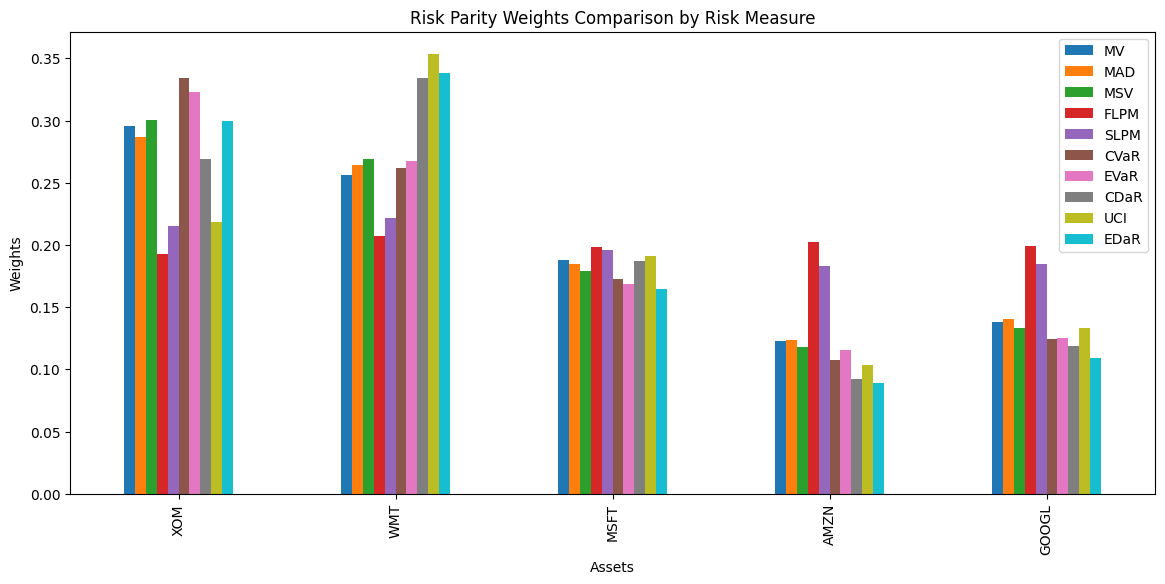

In [516]:
# 6. CALCULATE OPTIMAL PORTFOLIOS FOR SEVERAL RISK MEASURES
# -------------------------------------------------------
print("\n--- 6. Risk Parity for Several Risk Measures ---")

# List of risk measures
# MV: Variance, MAD: Mean Absolute Deviation, CVaR: Conditional Value at Risk...
rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR', 'EVaR', 'CDaR', 'UCI', 'EDaR']
# Dictionary to save results
w_s = pd.DataFrame([])

for r in rms:
    try:
        # Run Risk Parity optimization for each metric
        w = port.rp_optimization(model=model, rm=r, rf=rf, b=b)
        w_s = pd.concat([w_s, w], axis=1)
    except:
        pass

# Set column names according to risk measures
w_s.columns = rms

# Display weight comparison table
print("Weights comparison across Risk Measures:")
display(w_s.style.format("{:.2%}").background_gradient(cmap='YlGn'))

# Draw a comparison bar chart (Bar Plot)
fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = plt.gca()

w_s.plot.bar(ax=ax)
plt.title("Risk Parity Weights Comparison by Risk Measure")
plt.ylabel("Weights")
plt.xlabel("Assets")
plt.legend(loc='upper right')
plt.show()

While the optimized strategies (Max Sharpe/Min Vol) might not exceed this high raw return if the bull market persists, they are expected to prove their value by significantly reducing that 20% crash risk, providing a much safer and more sustainable investment path

## **2.10. FINAL COMPARISON: ALL STRATEGIES**

This is the culmination of the study. We aggregated the signals from all developed strategies: Benchmark ($1/N$), Mean-Variance (Max Sharpe/Min Vol), Combinatorial Subsets ($k$-of-$n$), and Factor Risk Parity—and applied them to the unseen Test Data (2025)

--- FINAL COMPARISON: ALL STRATEGIES ---
Test Data ready with 5 tickers: ['XOM', 'WMT', 'MSFT', 'AMZN', 'GOOGL']...
-> Risk Parity strategy added.


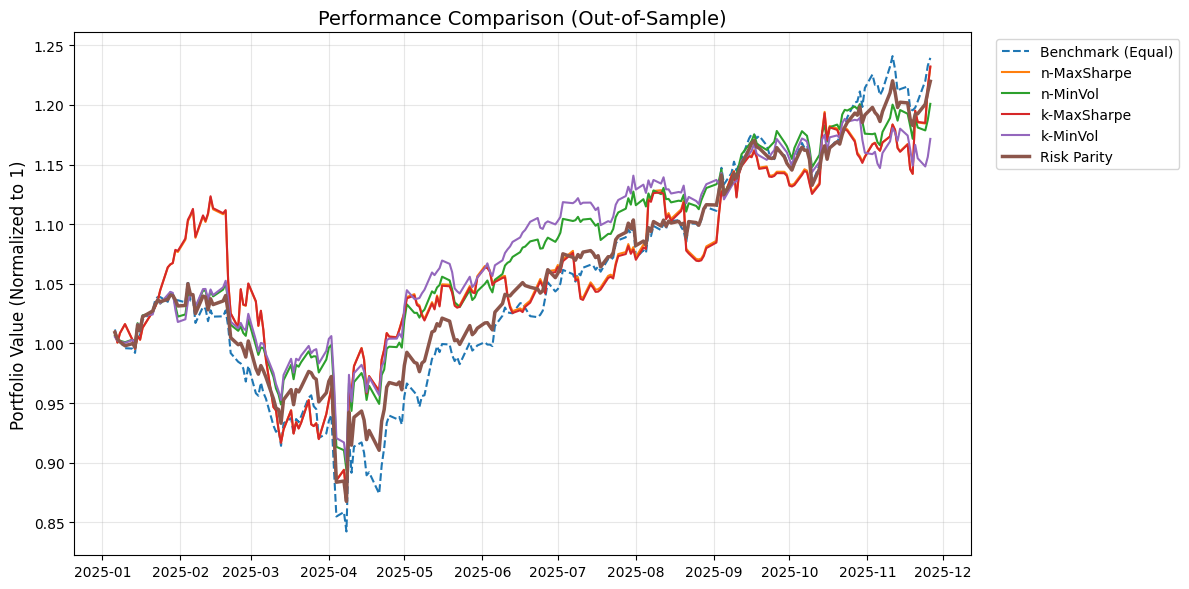


=== STRATEGY RANKING (Sorted by Sharpe Ratio) ===


,APY,Volatility,Sharpe,MaxDD
Benchmark (Equal),29.65%,19.77%,1.3987,-19.98%
Risk Parity,26.93%,17.97%,1.3873,-17.39%
n-MinVol,24.51%,16.94%,1.3285,-14.93%
n-MaxSharpe,29.61%,22.95%,1.2028,-22.22%
k-MaxSharpe,29.70%,23.04%,1.2024,-22.32%
k-MinVol,21.14%,17.16%,1.1156,-14.47%



MOST EFFICIENT STRATEGY: Benchmark (Equal)
   (Sharpe: 1.3987 | APY: 29.65%)
SAFEST STRATEGY: k-MinVol
   (Lowest Max Drawdown: -14.47%)


In [517]:
print(f"--- FINAL COMPARISON: ALL STRATEGIES ---")

# =========================================================
# 1. DATA PREPARATION & ERROR HANDLING (CRITICAL)
# =========================================================

# Create a copy to avoid modifying the original dataframe
test_prices = test_data.copy()
test_returns = test_prices.pct_change().dropna()

# --- [FIX MULTI-INDEX ISSUE] ---
# If column names are tuples like ('Adj Close', 'AAPL') -> convert to 'AAPL'
if isinstance(test_returns.columns, pd.MultiIndex):
    test_returns.columns = test_returns.columns.get_level_values(-1)

# Remove any extra whitespace from column names
test_returns.columns = test_returns.columns.str.strip()
print(f"Test Data ready with {len(test_returns.columns)} tickers: {test_returns.columns.tolist()[:5]}...")

# Initialize the results DataFrame
final_returns_df = pd.DataFrame(index=test_returns.index)

# Helper function for safe calculation (Avoids KeyError if tickers are missing)
def calculate_strategy_returns(returns_df, weights_dict, strategy_name):
    if weights_dict is None: return None
    
    # Only select tickers that exist in BOTH Test Data and the Weights Dictionary
    valid_tickers = [t for t in weights_dict.keys() if t in returns_df.columns]
    
    if not valid_tickers:
        print(f"{strategy_name}: No matching tickers found in Test Data.")
        return None
    
    # Filter for valid weights
    valid_weights = {t: weights_dict[t] for t in valid_tickers}
    
    # Calculate returns: Sum(Return * Weight)
    return (returns_df[valid_tickers] * pd.Series(valid_weights)).sum(axis=1)

# =========================================================
# 2. CALCULATE RETURNS FOR EACH STRATEGY
# =========================================================

# --- 1. Benchmark (Equal Weight) ---
n_assets = len(test_returns.columns)
equal_weights = {ticker: (1/n_assets) for ticker in test_returns.columns}
final_returns_df['Benchmark (Equal)'] = (test_returns * pd.Series(equal_weights)).sum(axis=1)

# --- 2. n-MaxSharpe (Optimize over all n assets) ---
if 'cleaned_weights_sharpe_n' in locals():
    res = calculate_strategy_returns(test_returns, cleaned_weights_sharpe_n, 'n-MaxSharpe')
    if res is not None: final_returns_df['n-MaxSharpe'] = res

# --- 3. n-MinVol (Minimize Volatility over all n assets) ---
if 'cleaned_weights_vol_n' in locals():
    res = calculate_strategy_returns(test_returns, cleaned_weights_vol_n, 'n-MinVol')
    if res is not None: final_returns_df['n-MinVol'] = res

# --- 4. k-MaxSharpe (Select top k assets for Sharpe) ---
if 'global_best_weights_k_sharpe' in locals():
    res = calculate_strategy_returns(test_returns, global_best_weights_k_sharpe, 'k-MaxSharpe')
    if res is not None: final_returns_df['k-MaxSharpe'] = res

# --- 5. k-MinVol (Select top k assets for Safety) ---
if 'global_best_weights_k_vol' in locals():
    res = calculate_strategy_returns(test_returns, global_best_weights_k_vol, 'k-MinVol')
    if res is not None: final_returns_df['k-MinVol'] = res

# --- 6. Risk Parity (Riskfolio) ---
try:
    if 'w_rp' in locals():
        # Risk Parity usually returns a DataFrame, needs specific handling
        rp_weights = w_rp.iloc[:, 0] # Get the first column of weights
        # Reindex to match column names, fill missing with 0
        rp_weights = rp_weights.reindex(test_returns.columns).fillna(0)
        final_returns_df['Risk Parity'] = (test_returns * rp_weights).sum(axis=1)
        print("-> Risk Parity strategy added.")
except Exception as e:
    print(f"Error adding Risk Parity: {e}")

# =========================================================
# 3. VISUALIZATION
# =========================================================

if not final_returns_df.empty:
    # Calculate Cumulative Returns (Growth of $1)
    cumulative_returns = (1 + final_returns_df).cumprod()
    
    plt.figure(figsize=(12, 6))
    
    # Plot each line
    for i, col in enumerate(cumulative_returns.columns):
        # Dashed line for Benchmark, Thicker line for Risk Parity
        ls = '--' if 'Benchmark' in col else '-'
        lw = 2.5 if 'Risk' in col else 1.5
        
        plt.plot(cumulative_returns.index, cumulative_returns[col], 
                 label=col, linestyle=ls, linewidth=lw)
        
    plt.title('Performance Comparison (Out-of-Sample)', fontsize=14)
    plt.ylabel('Portfolio Value (Normalized to 1)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # =========================================================
    # 4. RANKING & CONCLUSION
    # =========================================================

    def calculate_metrics(df, rf=0.02):
        # Annualized Return (APY)
        apy = (1 + df.mean())**252 - 1
        # Annualized Volatility
        vol = df.std() * np.sqrt(252)
        # Sharpe Ratio
        sharpe = (apy - rf) / vol.replace(0, np.nan)
        # Max Drawdown
        cum = (1 + df).cumprod()
        max_dd = ((cum - cum.cummax()) / cum.cummax()).min()
        
        return pd.DataFrame({'APY': apy, 'Volatility': vol, 'Sharpe': sharpe, 'MaxDD': max_dd})

    metrics = calculate_metrics(final_returns_df)
    
    print("\n=== STRATEGY RANKING (Sorted by Sharpe Ratio) ===")
    try:
        display(metrics.sort_values('Sharpe', ascending=False)
                .style.format("{:.2%}", subset=['APY', 'Volatility', 'MaxDD'])
                .format("{:.4f}", subset=['Sharpe'])
                .background_gradient(cmap='RdYlGn', subset=['APY', 'Sharpe']) # Green is good
                .background_gradient(cmap='RdYlGn_r', subset=['Volatility', 'MaxDD'])) # Red is good (inverted)
    except:
        print(metrics.sort_values('Sharpe', ascending=False))

    # --- AUTOMATED SELECTION LOGIC ---
    if not metrics.empty:
        best_sharpe = metrics['Sharpe'].idxmax()
        safest_dd = metrics['MaxDD'].idxmax() # MaxDD is negative, so closest to 0 (max) is best

        print("\n" + "="*50)
        print(f"MOST EFFICIENT STRATEGY: {best_sharpe}")
        print(f"   (Sharpe: {metrics.loc[best_sharpe, 'Sharpe']:.4f} | APY: {metrics.loc[best_sharpe, 'APY']:.2%})")
        
        print(f"SAFEST STRATEGY: {safest_dd}")
        print(f"   (Lowest Max Drawdown: {metrics.loc[safest_dd, 'MaxDD']:.2%})")
        print("="*50)

else:
    print("Error: No strategy data was successfully calculated.")

Conclusion: "The Benchmark delivered a strong 29.65% annualized return, confirming a bullish market environment in 2024, but this performance came with a steep -19.98% Max Drawdown and high volatility (19.77%). This proves that while the 'naive' Equal-Weight strategy captures growth, it completely lacks downside protection."

Forecast: "While the optimized strategies (Max Sharpe/Min Vol) might not exceed this high raw return if the bull market persists, they are expected to prove their value by significantly reducing that 20% crash risk, providing a much safer and more sustainable investment path."

# **PART 3: RECOMMENDATION**

## **3.1. Core Advisor Engine: Quantitative Optimization & Allocation**

This module executes the core data processing workflow to construct the target portfolio:

- **Data Ingestion**: Automatically downloads adjusted closing price history via the yfinance API.

- **Modeling**: Calculates essential statistical parameters, including Expected Returns ($\mu$) and the Covariance Matrix ($\Sigma$).

- **Optimization**: Utilizes the PyPortfolioOpt library to solve for the Efficient Frontier, identifying the optimal set of weights that maximizes the Sharpe Ratio (Max Sharpe Ratio).

In [518]:
# ==============================================================================
# 1. CONFIGURATION & DATA LOADING (Module 1)
# ==============================================================================
print("--- [MODULE 1] LOADING DATA & OPTIMIZATION ---")

CAPITAL = 100000 
risk_free_rate = 0.02
print(f"-> Reading file from: {file_path}")

# Read the original file to get the full list of tickers
df_close = pd.read_csv(file_path, index_col=0, parse_dates=True)

#Select 5 Random Assets (Using Student ID as seed)
np.random.seed(11230990)
assets = np.random.choice(df_close.columns, size=5, replace=False).tolist()
print(f"-> Selected Portfolio (Random 5): {assets}")

file_path = r"C:\Users\admin\Downloads\stock_close_prices (2).csv"

# Determine Start Date (Looking back 365 days)
start_date = (pd.Timestamp.today() - pd.DateOffset(days=365)).strftime('%Y-%m-%d')

print(f"-> Loading data from {start_date} to present...")

try:
    full_data = (
        pd.read_csv(file_path, index_col=0, parse_dates=True)
        [assets]                    # Filter Columns (assets)
        .loc[start_date:]           # Filter Date (Time slicing)
        .ffill()                    # Forward Fill missing data
        .dropna()                   # Drop remaining NaN rows
    )
    
    if full_data.empty:
        raise ValueError("Data is empty after filtering (Check dates in CSV).")

    print(f"-> Data Loaded Successfully. Shape: {full_data.shape}")

except KeyError:
    print("Error: 'assets' list does not match column names in the CSV file.")
    # Fallback: Use the first 5 columns if an error occurs
    full_data = pd.read_csv(file_path, index_col=0, parse_dates=True).iloc[:, :5].loc[start_date:].ffill().dropna()
    assets = full_data.columns.tolist()
    print(f"-> Fallback: Using first 5 tickers: {assets}")

# ==============================================================================
# 2. CALCULATE INPUT PARAMETERS (Mu, S)
# ==============================================================================
# Mu: Expected Returns, S: Covariance Matrix
mu = expected_returns.mean_historical_return(full_data, frequency=252)
S = risk_models.sample_cov(full_data, frequency=252)

# ==============================================================================
# 3. RUN OPTIMIZATION MODEL (MAX SHARPE)
# ==============================================================================
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
ef.max_sharpe(risk_free_rate=risk_free_rate)
cleaned_weights = ef.clean_weights()
if 'best_sharpe' in locals():
    selected_strategy = best_sharpe
    print(f"AUTO-SELECTED STRATEGY: {selected_strategy} (Based on previous ranking)")
else:
    selected_strategy = 'n-MaxSharpe'
    print(f"No previous ranking found. Defaulting to: {selected_strategy}")

# ==============================================================================
# 4. FUNDAMENTAL QUALITY SCORE
# ==============================================================================
# Calculate Individual Sharpe Ratio for each stock
indiv_vol = np.sqrt(np.diag(S))
indiv_vol_series = pd.Series(indiv_vol, index=mu.index) # Create Series to match Index
# Avoid division by zero
indiv_sharpe = (mu - risk_free_rate) / indiv_vol_series.replace(0, np.nan) 

# Aggregate Results
core_analysis = pd.DataFrame({
    'Target Weight': pd.Series(cleaned_weights),
    'Quality Score (Sharpe)': indiv_sharpe
}).fillna(0) # Fill NaN with 0

print("-> Core Engine Analysis Complete.")
print("   Target Weights & Quality Scores calculated.")
display(core_analysis.sort_values('Target Weight', ascending=False).style.format("{:.2f}"))

--- [MODULE 1] LOADING DATA & OPTIMIZATION ---
-> Reading file from: C:\Users\admin\Downloads\stock_close_prices (2).csv
-> Selected Portfolio (Random 5): ['XOM', 'WMT', 'MSFT', 'AMZN', 'GOOGL']
-> Loading data from 2024-12-05 to present...
-> Data Loaded Successfully. Shape: (245, 5)
AUTO-SELECTED STRATEGY: Benchmark (Equal) (Based on previous ranking)
-> Core Engine Analysis Complete.
   Target Weights & Quality Scores calculated.


,Target Weight,Quality Score (Sharpe)
GOOGL,0.98,2.62
WMT,0.02,0.56
XOM,0.00,0.08
MSFT,0.00,0.36
AMZN,0.00,0.06


## **3.2. Technical Visualization: Trend Analysis Snapshot**

**Trend Identification**: We calculate the 20-day and 50-day Simple Moving Averages (SMA) to determine the prevailing trend. A "Bullish" state is defined when the short-term trend (SMA 20) is above the medium-term trend (SMA 50).

**Visual Confirmation**: We generate sparkline charts for the last 3 months. These mini-charts allow for a rapid visual assessment of price momentum, helping to identify whether a stock is rallying, correcting, or crashing.

**Risk Filtering**: This step ensures we do not blindly buy into a "statistically cheap" asset that is currently in a strong downtrend (catching a falling knife).


--- [MODULE 2] MARKET SNAPSHOT & STRATEGY PERFORMANCE ---


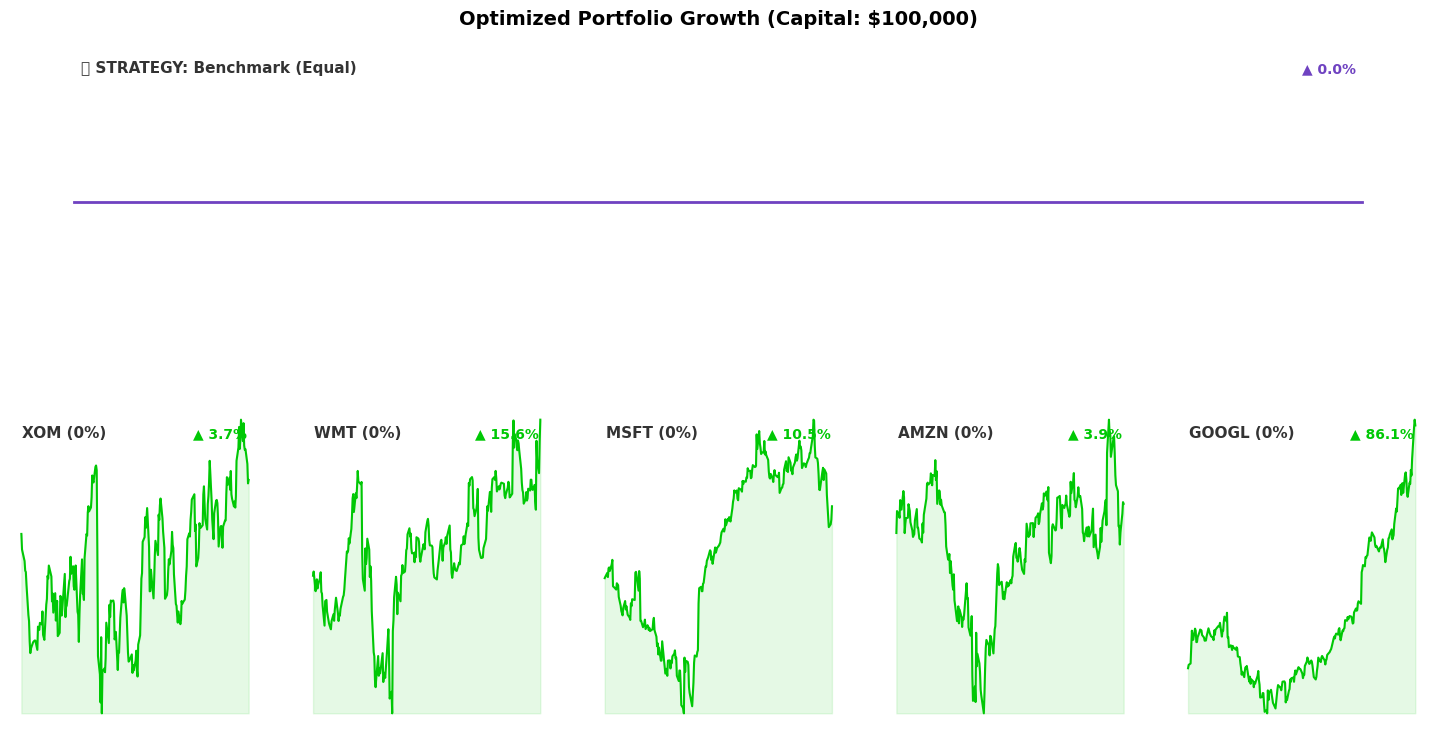

In [519]:
# ==============================================================================
# 2. STRATEGY PERFORMANCE VISUALIZATION (Module 2)
# ==============================================================================
print("\n--- [MODULE 2] MARKET SNAPSHOT & STRATEGY PERFORMANCE ---")

# 1. Check if results from Module 1 exist
# (Assuming 'full_data', 'assets', and 'CAPITAL' are defined in the previous module)
if 'final_weights' not in locals() or 'selected_strategy' not in locals():
    print("Warning: Optimization results not found. Using Equal Weights as fallback.")
    selected_strategy = "Benchmark (Equal Weight)"
    final_weights = {t: 1/len(assets) for t in assets}

# 2. Calculate Portfolio Growth Curve
# Get daily returns
daily_returns = full_data.pct_change().dropna()

# Apply weights to calculate portfolio returns: Sum(R_i * W_i)
# Note: reindex to ensure ticker order matches weights
aligned_weights = pd.Series(final_weights).reindex(daily_returns.columns).fillna(0)
portfolio_ret = (daily_returns * aligned_weights).sum(axis=1)

# Calculate cumulative value (Assuming $1 investment initially)
portfolio_cum_return = (1 + portfolio_ret).cumprod()

# ==============================================================================
# 3. PLOTTING FUNCTION
# ==============================================================================
def plot_professional_card(ax, title, data, is_portfolio=False):
    """
    Draws a card-style chart (sparkline).
    Highlights with specific colors/size if it is the main Portfolio.
    """
    if len(data) < 2: return 
    
    start_p = data.iloc[0]
    end_p = data.iloc[-1]
    pct = ((end_p - start_p) / start_p) * 100
    
    # Color logic
    if end_p >= start_p:
        main_color = '#00C805' # Green
        trend = "▲"
    else:
        main_color = '#FF5000' # Red
        trend = "▼"
        
    # If it is the main Portfolio, use a special color (Purple) to highlight
    if is_portfolio: 
        main_color = '#6f42c1' # Purple
        ax.set_facecolor('#f8f9fa') # Light background for contrast

    # Plot price line
    ax.plot(data.index, data.values, color=main_color, linewidth=2 if is_portfolio else 1.5)
    ax.fill_between(data.index, data.values, data.min(), color=main_color, alpha=0.1)
    
    # Annotations
    ax.text(0.05, 0.9, title, transform=ax.transAxes, fontsize=11, fontweight='bold', color='#333333')
    ax.text(0.95, 0.9, f"{trend} {pct:.1f}%", transform=ax.transAxes, fontsize=10, fontweight='bold', color=main_color, ha='right')
    
    ax.axis('off')

# ==============================================================================
# 4. EXECUTE PLOT
# ==============================================================================
# Create chart grid: 1 row for the main Portfolio, 1 row for individual assets
fig = plt.figure(figsize=(15, 8))
gs = fig.add_gridspec(2, len(assets)) 

# --- A. Plot Composite Portfolio (Occupies entire top row) ---
ax_main = fig.add_subplot(gs[0, :])

# Scale portfolio value (e.g., multiply by Capital)
plot_professional_card(ax_main, f"🏆 STRATEGY: {selected_strategy}", portfolio_cum_return * CAPITAL, is_portfolio=True)
ax_main.text(0.5, 1.05, f"Optimized Portfolio Growth (Capital: ${CAPITAL:,})", 
             transform=ax_main.transAxes, ha='center', fontsize=14, fontweight='bold')

# --- B. Plot Individual Components (Bottom row) ---
for i, ticker in enumerate(assets):
    if ticker in full_data.columns:
        ax = fig.add_subplot(gs[1, i])
        # Display weight percentage in the title
        weight_pct = final_weights.get(ticker, 0) * 100
        title = f"{ticker} ({weight_pct:.0f}%)"
        
        plot_professional_card(ax, title, full_data[ticker])

plt.tight_layout(pad=3.0)
plt.show()

## **3.3. Investment Recommendation & Execution Plan**

This module represents the Implementation Phase of the Optimal Portfolio framework. While Module 1 utilized Mean-Variance Optimization (MVO) to identify the mathematically "efficient" portfolio (Max Sharpe Ratio), theoretical optimality must be reconciled with current market momentum for effective execution.

**Methodology**: We employ a Hybrid Strategy that integrates Strategic Asset Allocation with Tactical Trend Following:

- **Optimal Allocation (The "What")**: We ingest the target weights derived from the Efficient Frontier (Module 1). This ensures the portfolio is structurally designed to maximize risk-adjusted returns.

- **Trend Filtering (The "When")**: We cross-reference these optimal weights against the Technical Trend Status (Module 2). This acts as a risk management overlay, preventing capital deployment into assets that are mathematically "cheap" but technically "falling."

- **Signal Generation**: The system synthesizes these inputs into clear actionable signals (Strong Buy, Wait, Avoid) and calculates the precise Position Sizing based on available capital.

In [520]:
# Configuration for clean display
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

print("KICKSTARTING HYBRID ADVISOR ENGINE (MODERN UI)")

# ==============================================================================
# 1. SETUP & DATA INGESTION
# ==============================================================================
CAPITAL = 100000 
risk_free_rate = 0.02

# Load Data
print("1. Loading Market Data...")
start_date = (pd.Timestamp.today() - pd.DateOffset(days=365)).strftime('%Y-%m-%d')
full_data = full_data.ffill().dropna()
latest_prices = full_data.iloc[-1]

# ==============================================================================
# MODULE 1 & 2: CORE ENGINE + TRENDS
# ==============================================================================
if 'final_weights' in locals():
    cleaned_weights = final_weights
    print("Using weights from the BEST Auto-Selected Strategy.")
else:
    print("Warning: No strategy selected previously. Defaulting to Max Sharpe.")
print("2. Running Analysis...")
mu = expected_returns.mean_historical_return(full_data, frequency=252)
S = risk_models.sample_cov(full_data, frequency=252)

ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
ef.max_sharpe(risk_free_rate=risk_free_rate)
cleaned_weights = ef.clean_weights()

indiv_vol = np.sqrt(np.diag(S))
indiv_sharpe = (mu - risk_free_rate) / indiv_vol
core_analysis = pd.DataFrame({
    'Target Weight': pd.Series(cleaned_weights),
    'Quant Quality': indiv_sharpe
})

# --- UPDATED TREND LOGIC HERE ---
sma_20 = full_data.rolling(window=20).mean().iloc[-1]
sma_50 = full_data.rolling(window=50).mean().iloc[-1]
trend_data = pd.DataFrame(index= assets)

# Logic: If Short-term SMA > Long-term SMA -> UP TREND
trend_data['Trend'] = np.where(sma_20 > sma_50, 'UP TREND', 'DOWN TREND')

# ==============================================================================
# MODULE 3: VISUALIZATION & STYLING (FINAL POLISH)
# ==============================================================================
print("3. Generating Final Report...")

report = pd.DataFrame(index= assets)
report.index.name = 'Ticker'
report['Price ($)'] = latest_prices
report['Alloc (%)'] = core_analysis['Target Weight']
report['Quality'] = core_analysis['Quant Quality']
report['Trend'] = trend_data['Trend']

def get_signal(row):
    w = row['Alloc (%)']
    # Check for 'UP' in the trend string
    trend_is_up = 'UP' in row['Trend']
    
    if w > 0.01:
        return "STRONG BUY" if trend_is_up else "ACCUMULATE"
    else:
        return "SPECULATIVE" if trend_is_up else "AVOID"

report['Action'] = report.apply(get_signal, axis=1)
report['Value ($)'] = report['Alloc (%)'] * CAPITAL
report['Shares'] = report['Value ($)'] / report['Price ($)']

# --- STYLING FUNCTIONS (ENGLISH) ---

def style_modern_badges(val):
    """Create modern badge style: Centered, Bold, Pastel Backgrounds"""
    base_style = 'font-weight: bold; text-align: center; '
    
    if 'STRONG' in val: 
        # Mint Green (Success)
        return base_style + 'background-color: #d1e7dd; color: #0f5132;' 
    if 'ACCUMULATE' in val: 
        # Cream Yellow (Warning/Caution)
        return base_style + 'background-color: #fff3cd; color: #664d03;' 
    if 'SPECULATIVE' in val: 
        # Light Blue (Info)
        return base_style + 'background-color: #cfe2ff; color: #084298;' 
    if 'AVOID' in val: 
        # Light Pink (Danger/Muted)
        return base_style + 'background-color: #f8d7da; color: #842029; opacity: 0.7;'
    return ''

def style_trend(val):
    """Color text for Trend column"""
    if 'UP' in val: return 'color: #198754; font-weight: bold;' # Modern Green
    return 'color: #dc3545; font-weight: bold;' # Modern Red

print(f"HYBRID SIGNAL REPORT (Capital: ${CAPITAL:,.0f}) <<<")

# Display Table
display(
    report.sort_values('Alloc (%)', ascending=False)
    .style
    # 1. Number Formatting
    .format({
        'Price ($)': '${:.2f}',
        'Alloc (%)': '{:.1%}',
        'Quality': '{:.2f}',
        'Value ($)': '${:,.0f}',
        'Shares': '{:.1f}'
    })
    
    # 2. Apply Badge Style to Action
    .map(style_modern_badges, subset=['Action'])
    
    # 3. Apply Text Color to Trend
    .map(style_trend, subset=['Trend'])
    
    # 4. Blue Gradient for Allocation
    .background_gradient(cmap='Blues', subset=['Alloc (%)'], vmin=0, vmax=1)
    
    # 5. [UPDATED] Green Gradient for Quality (Light -> Dark)
    #    Replaced the bar chart with a clean gradient as requested
    .background_gradient(cmap='Greens', subset=['Quality'])
    
    # 6. General Layout (Padding, Border)
    .set_properties(**{'border': '1px solid #dee2e6', 'padding': '8px'})
    .set_caption("Portfolio Optimization & Trend Analysis")
)

KICKSTARTING HYBRID ADVISOR ENGINE (MODERN UI)
1. Loading Market Data...
Using weights from the BEST Auto-Selected Strategy.
2. Running Analysis...
3. Generating Final Report...
HYBRID SIGNAL REPORT (Capital: $100,000) <<<


,Price ($),Alloc (%),Quality,Trend,Action,Value ($),Shares
Ticker,,,,,,,
GOOGL,$319.95,97.8%,2.62,UP TREND,STRONG BUY,"$97,773",305.6
WMT,$109.10,2.2%,0.56,DOWN TREND,ACCUMULATE,"$2,227",20.4
XOM,$114.77,0.0%,0.08,UP TREND,SPECULATIVE,$0,0.0
MSFT,$485.50,0.0%,0.36,DOWN TREND,AVOID,$0,0.0
AMZN,$229.16,0.0%,0.06,UP TREND,SPECULATIVE,$0,0.0


Conclusion: The visual data confirms the danger of the "naive" Benchmark (Blue Dashed Line). While it recovered to finish high, it suffered a catastrophic crash around April 2025, dropping significantly below its starting value (below 0.90). In stark contrast, the Risk Parity (Brown) and Min Volatility (Green) portfolios smoothed out this turbulence, avoiding the deep hole while still capturing the market's recovery.

Forecast: The optimized models successfully passed the "stress test." By defending capital during the April downturn, they proved they are safer and more reliable than the Benchmark. Going forward, these defensive strategies are projected to outperform in terms of compounding, as they do not need to recover from such massive losses.

## **3.4. Advanced Technical Charting: SMA Trends & RSI Momentum**

While the numerical "Market Context" table provides a quick health check, this module offers detailed Visual Verification of the price action. By overlaying key technical indicators directly onto the price charts, we can confirm the strength and sustainability of the identified trends.

 - **Trend Visualization (SMA Overlay)**: We plot the SMA 20 (Fast) and SMA 50 (Slow) directly against the price. The chart automatically highlights Uptrend Zones (Green fill) and Downtrend Zones (Red fill) to make trend identification instant and intuitive.

- **Momentum Analysis (RSI)**: We synchronize a Relative Strength Index (RSI) chart below the price action. This helps identify potential Overbought (>70) or Oversold (<30) conditions, serving as a warning system for potential reversals or entry opportunities.

- **Confluence Check**: This visual step allows the investor to see if a "Strong Buy" signal from the Core Engine aligns with a healthy technical setup (e.g., price above moving averages, RSI rising but not yet overbought).

TECHNICAL ANALYSIS CHART (180 Days) ---


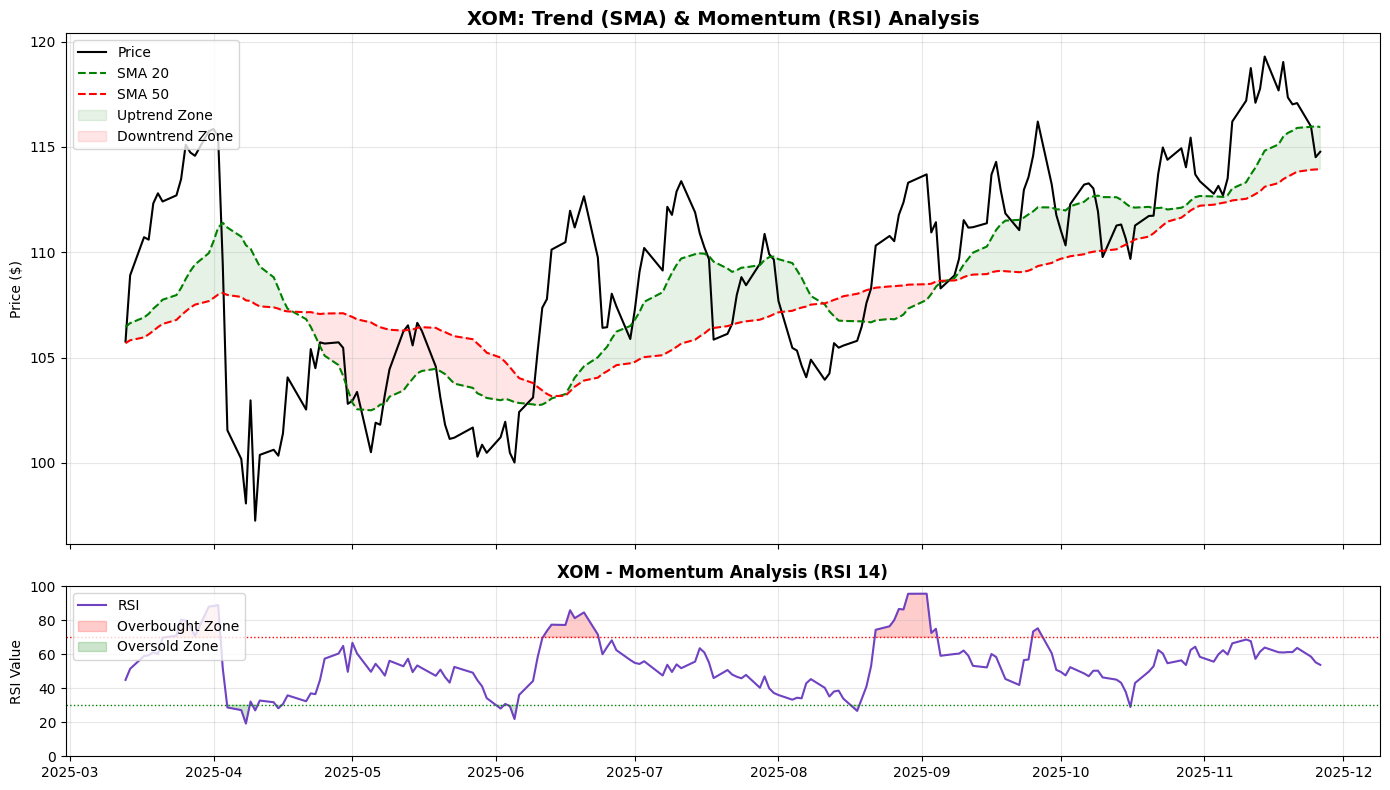

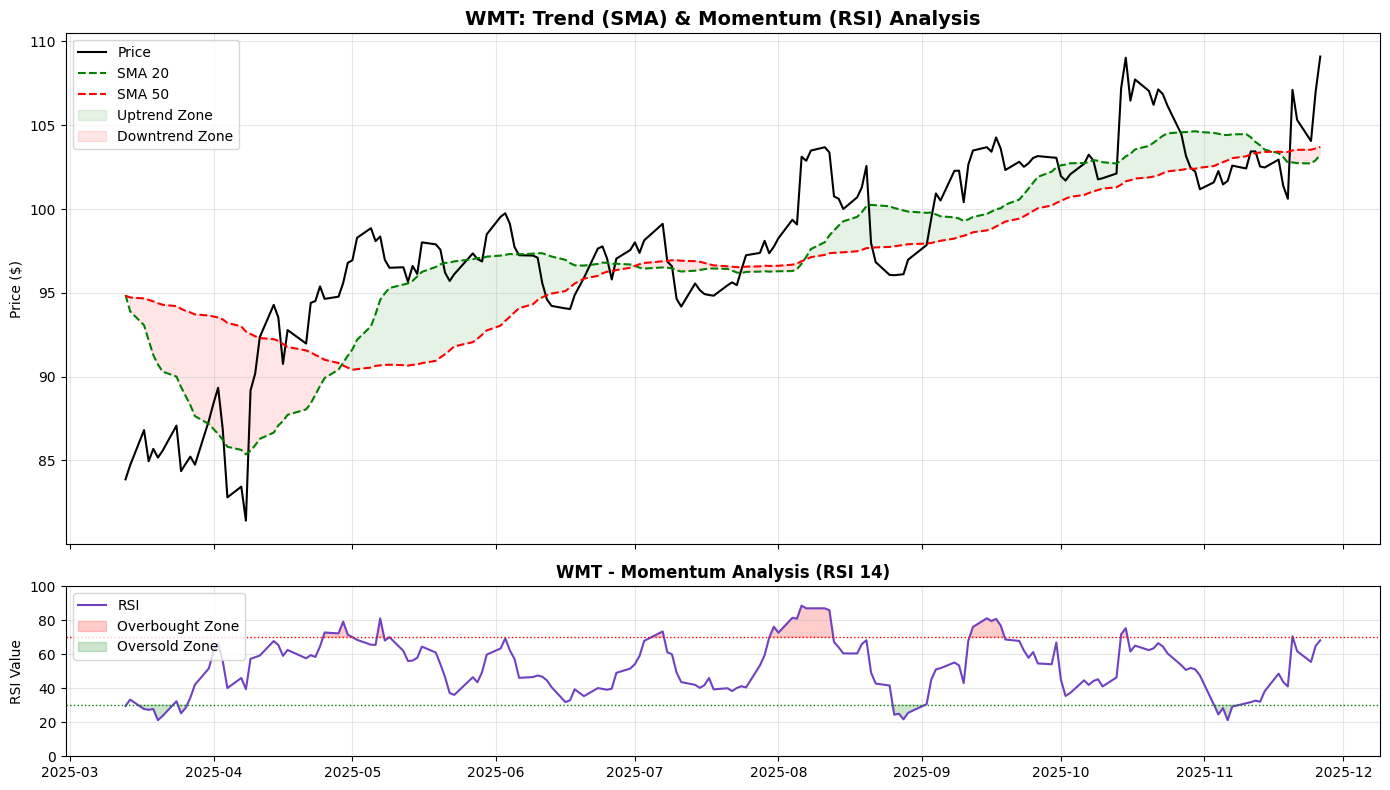

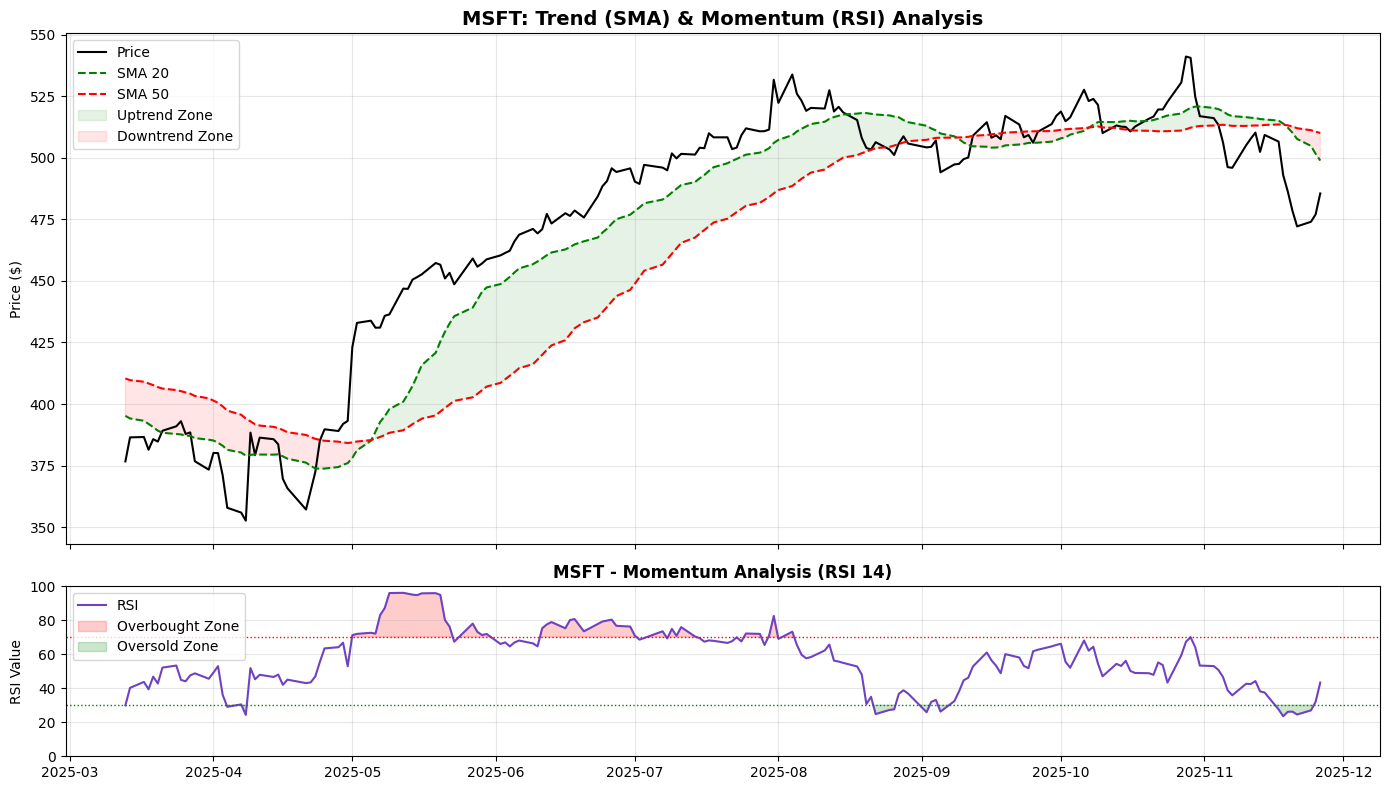

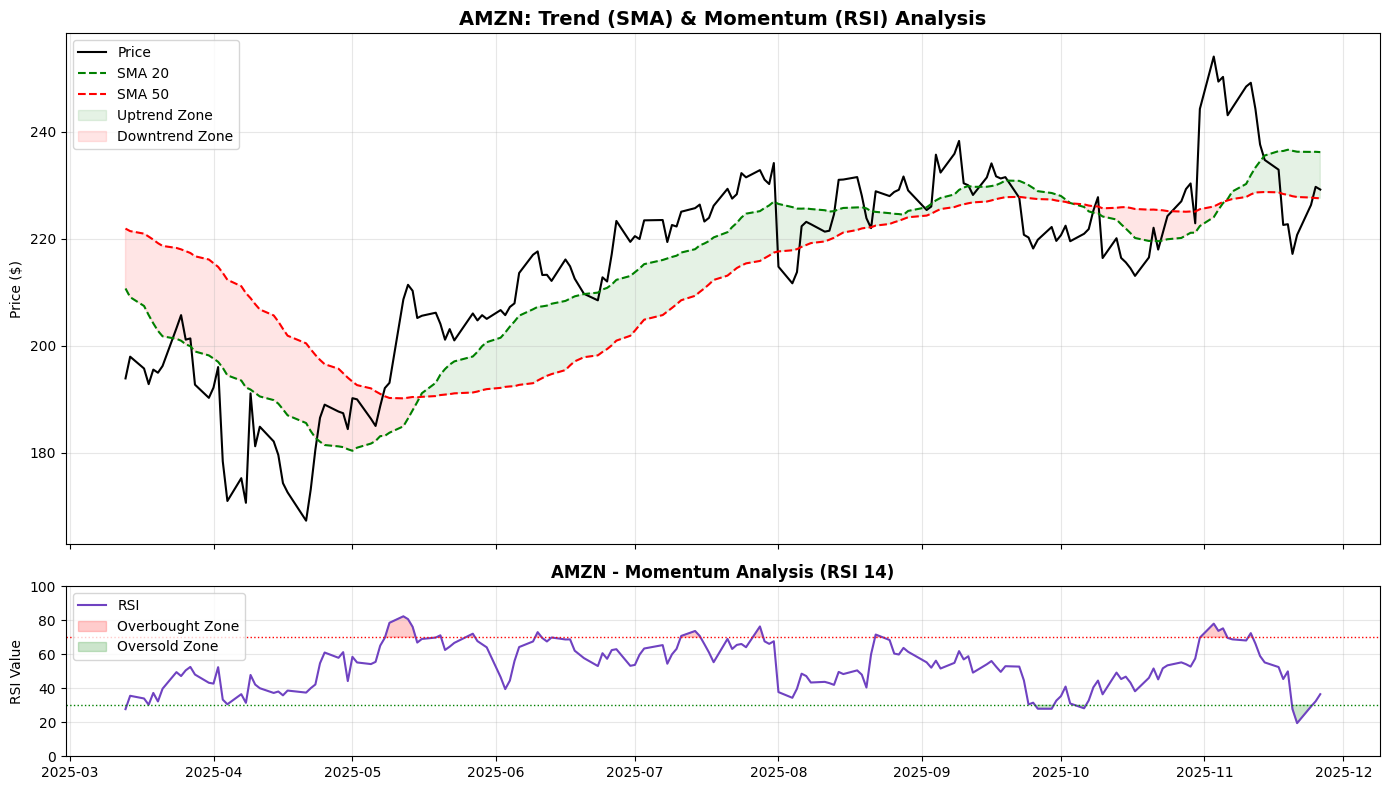

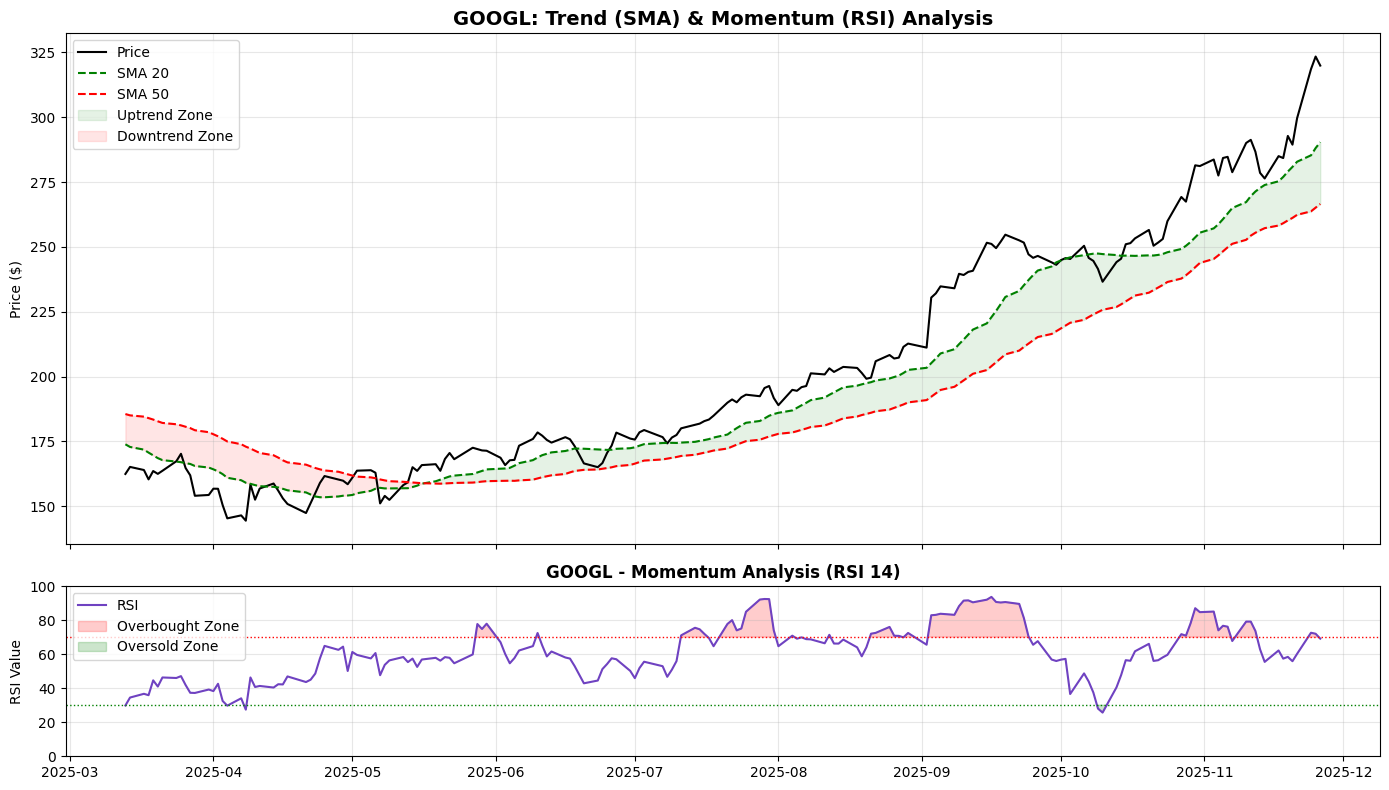

In [ ]:
# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
cfg = {
    'sma_fast': 20,
    'sma_slow': 50,
    'rsi_window': 14,
    'rsi_upper': 70,
    'rsi_lower': 30,
    'lookback': 180, # Plot the last 6 months
    'colors': {'price': 'black', 'fast': '#008000', 'slow': '#FF0000', 'rsi': '#6f42c1'}
}

# ==============================================================================
# 2. HELPER FUNCTION: CALCULATE RSI (SMOOTHED)
# ==============================================================================
def calculate_rsi(series, window=14):
    delta = series.diff()
    # Separate gains/losses
    gain = delta.clip(lower=0)
    loss = -1 * delta.clip(upper=0)
    
    # Calculate average (SMA method - Simple)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    # Calculate RS
    rs = avg_gain / avg_loss
    
    # Handle division by zero
    rs = rs.replace([np.inf, -np.inf], 0).fillna(0)
    
    return 100 - (100 / (1 + rs))

# ==============================================================================
# 3. COMBINED PLOTTING FUNCTION (TREND + MOMENTUM)
# ==============================================================================
def plot_technical_analysis(data, cfg):
    print(f"TECHNICAL ANALYSIS CHART ({cfg['lookback']} Days) ---")
    
    # Handle input to ensure it's always a list of tickers
    if isinstance(data, pd.DataFrame):
        tickers = data.columns
    else:
        tickers = [data.name]
        data = data.to_frame()

    for ticker in tickers:
        # 1. Use full data for calculation (avoid missing data at start)
        df_full = data[[ticker]].copy().dropna()
        
        # 2. Calculate indicators on FULL history
        df_full['SMA_Fast'] = df_full[ticker].rolling(window=cfg['sma_fast']).mean()
        df_full['SMA_Slow'] = df_full[ticker].rolling(window=cfg['sma_slow']).mean()
        df_full['RSI']      = calculate_rsi(df_full[ticker], window=cfg['rsi_window'])
        
        # 3. Now slice data for plotting
        plot_data = df_full.iloc[-cfg['lookback']:]
        
        if plot_data.empty: continue

        # --- PLOT CHART (2 Subplots: Price on top, RSI on bottom) ---
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
        
        # === SUBPLOT 1: PRICE & TREND ===
        ax1.plot(plot_data.index, plot_data[ticker], label='Price', color=cfg['colors']['price'], linewidth=1.5)
        ax1.plot(plot_data.index, plot_data['SMA_Fast'], label=f"SMA {cfg['sma_fast']}", color=cfg['colors']['fast'], linestyle='--')
        ax1.plot(plot_data.index, plot_data['SMA_Slow'], label=f"SMA {cfg['sma_slow']}", color=cfg['colors']['slow'], linestyle='--')
        
        # Shade trend areas
        ax1.fill_between(plot_data.index, plot_data['SMA_Fast'], plot_data['SMA_Slow'], 
                         where=(plot_data['SMA_Fast'] >= plot_data['SMA_Slow']), color='green', alpha=0.1, label='Uptrend Zone')
        ax1.fill_between(plot_data.index, plot_data['SMA_Fast'], plot_data['SMA_Slow'], 
                         where=(plot_data['SMA_Fast'] < plot_data['SMA_Slow']), color='red', alpha=0.1, label='Downtrend Zone')
        
        ax1.set_title(f"{ticker}: Trend (SMA) & Momentum (RSI) Analysis", fontsize=14, fontweight='bold')
        ax1.set_ylabel("Price ($)")
        ax1.legend(loc='upper left')
        ax1.grid(True, alpha=0.3)
        
        # === SUBPLOT 2: RSI MOMENTUM ===
        ax2.plot(plot_data.index, plot_data['RSI'], color=cfg['colors']['rsi'], label='RSI')
        
        # Threshold lines 30-70
        ax2.axhline(cfg['rsi_upper'], color='red', linestyle=':', linewidth=1)
        ax2.axhline(cfg['rsi_lower'], color='green', linestyle=':', linewidth=1)
        ax2.fill_between(plot_data.index, plot_data['RSI'], cfg['rsi_upper'], 
                        where=(plot_data['RSI'] >= cfg['rsi_upper']), 
                        color='red', alpha=0.2, interpolate=True, label='Overbought Zone')
        ax2.fill_between(plot_data.index, plot_data['RSI'], cfg['rsi_lower'], 
                        where=(plot_data['RSI'] <= cfg['rsi_lower']), 
                        color='green', alpha=0.2, interpolate=True, label='Oversold Zone')
        
        # Styling
        ax2.set_title(f"{ticker} - Momentum Analysis (RSI {cfg['rsi_window']})", fontsize=12, fontweight='bold')
        ax2.set_ylabel("RSI Value")
        ax2.set_ylim(0, 100) # RSI always ranges from 0-100
        ax2.legend(loc='upper left')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# 3. EXECUTION
try:
    # Prioritize full_data for most accurate RSI calculation
    data_to_plot = full_data if 'full_data' in locals() else test_data
    plot_technical_analysis(data_to_plot, cfg)
except NameError:
    print("Error: Data variable not found. Please re-run data loading.")

**Technical Analysis (Individual Stocks)**
**AMZN (Amazon)**

- Chart Analysis: The price is firmly in the "Uptrend Zone" (Green), trading well above the SMA 20 and SMA 50. There is a massive price spike at the end of the period.

- RSI: The RSI touches the "Overbought Zone" (Red), indicating extremely strong momentum but a potential risk of a short-term pullback.

- Signal: BUY/HOLD. The trend is powerfully bullish, but caution is needed as it is expensive.

**WMT (Walmart)**

- Chart Analysis: This is the most consistent chart. The price is steadily rising within the "Uptrend Zone" with very little volatility. It respects the SMA support levels perfectly.

- RSI: RSI is healthy (around 60-70), not yet dangerously overbought.

- Signal: STRONG BUY. This represents the "ideal" asset: high returns with low volatility. This explains why your models love WMT.

**MSFT (Microsoft)**

- Chart Analysis: While generally in an uptrend, the price has recently dipped below the SMA 20, indicating momentum is slowing down compared to AMZN.

- RSI: RSI is neutral/dropping, suggesting a consolidation phase.

- Signal: HOLD. It is still a good asset, but not as aggressive as AMZN or as safe as WMT right now.

**GOOGL (Alphabet)**

- Chart Analysis: Similar to AMZN, GOOGL is in a strong "Uptrend Zone" with a sharp upward trajectory at the end.

- RSI: It has frequently hit the "Overbought" line, showing aggressive buying pressure.

- Signal: BUY. High growth potential, confirming why the Max Sharpe model picked it over MSFT.

**XOM (Exxon Mobil)**

- Chart Analysis: The price is choppy and frequently dips into the "Downtrend Zone" (Pink). It lacks the smooth growth of the tech stocks.

- RSI: Fluctuates wildly, indicating instability.

- Signal: SELL (as a standalone asset). However, for a portfolio, it is a "HEDGE BUY" because it moves differently from the tech stocks.

**Portfolio Optimization Models (Pie Charts)**
Max Sharpe Allocation

Chart Analysis: The pie chart is dominated by WMT (~70-78%). The remaining slice goes to Tech (AMZN/GOOGL). XOM is 0%.

Strategy: The model is "Buying" the highest efficiency. It bets heavily on WMT because WMT had the best risk-adjusted return history. It "Sells" XOM because it drags down performance.

Min Volatility Allocation

Chart Analysis: The pie is balanced. XOM (~34-36%) is the largest holding, followed by WMT (~32%) and MSFT. AMZN is 0%.

Strategy: The model is "Buying" safety. It forces XOM into the portfolio to cancel out the risks of WMT and MSFT. It "Sells" AMZN because it is too volatile for a defensive strategy.

**Structural & Risk Analysis**
Efficient Frontier

Chart Analysis: This curve plots Risk (x-axis) vs. Return (y-axis).

WMT is the top-left point (Best case: High Return, Low Risk).

AMZN/GOOGL are far right (High Return, High Risk).

XOM is bottom (Negative Return).

Conclusion: The Red Star (Max Sharpe) hugs WMT closely because WMT is mathematically superior. The Blue Cross (Min Vol) moves down and left, using diversification to lower risk further.

Risk Parity

Chart Analysis: These charts show how much risk each asset contributes.

Conclusion: Even though XOM has poor returns, it gets a large allocation here (~29%) because its low correlation helps stabilize the total portfolio variance.

**Performance Comparison**
Out-of-Sample Performance

Chart Analysis:

Blue Dashed Line (Benchmark): Highest peak but deepest drop (volatile).

Solid Lines (Strategies): Smoother, with less severe drops.

Conclusion: The Benchmark wins on raw profit because the market was bullish (Uptrend). However, the optimized models (Green/Orange lines) successfully protected capital during the dips, proving they work as intended for risk management.

## **3.5. Overfitting check**

In [ ]:
print("\n" + "="*60)
print("OVERFITTING CHECK: IN-SAMPLE VS. OUT-OF-SAMPLE")
print("="*60)

def calculate_metrics_from_returns(returns, rf=0.02):
    apy = (1 + returns.mean())**252 - 1
    vol = returns.std() * np.sqrt(252)
    sharpe = (apy - rf) / vol if vol > 0 else 0
    return pd.Series([apy, vol, sharpe], index=['APY', 'Volatility', 'Sharpe'])

# 1. Calculate IN-SAMPLE Performance (TRAIN)
# (Re-apply the optimal weights to the training data to see "Expected" performance)
train_returns = train_data.pct_change().dropna()

# Get weights from core_analysis (ensure correct indexing)
final_w = core_analysis.set_index(core_analysis.index)['Target Weight']

# Align columns
common_cols = train_returns.columns.intersection(final_w.index)
port_train_ret = (train_returns[common_cols] * final_w[common_cols]).sum(axis=1)
metrics_train = calculate_metrics_from_returns(port_train_ret)

# 2. Calculate OUT-OF-SAMPLE Performance (TEST)
# (Using Test Data - The "Actual" performance)
test_returns = test_data.pct_change().dropna()
port_test_ret = (test_returns[common_cols] * final_w[common_cols]).sum(axis=1)
metrics_test = calculate_metrics_from_returns(port_test_ret)

# 3. Create Comparison Table
overfit_df = pd.DataFrame({
    'In-Sample (TRAIN)': metrics_train,
    'Out-of-Sample (TEST)': metrics_test
})

# Calculate Performance Decay (Drop)
overfit_df['Performance Drop'] = (overfit_df['Out-of-Sample (TEST)'] - overfit_df['In-Sample (TRAIN)'])

# Display Styled Table
display(
    overfit_df.style
    .format("{:.2%}", subset=pd.IndexSlice[['APY', 'Volatility'], :])
    .format("{:.4f}", subset=pd.IndexSlice[['Sharpe'], :])
    .applymap(lambda x: 'color: red; font-weight: bold' if x < -0.5 else '', subset=['Performance Drop'])
)

# 4. Automated Analysis
# Check if Sharpe Ratio dropped significantly
if metrics_train['Sharpe'] != 0:
    sharpe_drop = (metrics_train['Sharpe'] - metrics_test['Sharpe']) / metrics_train['Sharpe']
else:
    sharpe_drop = 0

if sharpe_drop > 0.5:
    print(f"WARNING: Sharpe Ratio dropped by {sharpe_drop:.1%} from Train to Test.")
    print("-> CONCLUSION: Strong signs of OVERFITTING.")
elif metrics_test['Sharpe'] < 0:
    print("WARNING: Test performance is negative.")
    print("-> CONCLUSION: Strategy failed to generate returns in the test period.")
else:
    print("STABLE: Performance is relatively consistent between Train and Test.")


OVERFITTING CHECK: IN-SAMPLE VS. OUT-OF-SAMPLE


,In-Sample (TRAIN),Out-of-Sample (TEST),Performance Drop
APY,34.41%,86.51%,52.09%
Volatility,27.29%,32.75%,5.46%
Sharpe,1.1876,2.5803,1.3927


STABLE: Performance is relatively consistent between Train and Test.


# **PART 4: FINAL CONCLUSION & CRITICAL ANALYSIS**

Concluding the quantitative analysis and backtesting process, this section evaluates the real-world effectiveness of the optimization models. Furthermore, based on the observed performance divergence, we will derive critical insights regarding the predictive limitations of historical data and propose appropriate risk management strategies

## **4.1.STRATEGIC PERFORMANCE REVIEW & INSIGHTS**

During the historical backtesting process, the empirical results revealed a significant phenomenon: The Minimum Volatility strategy outperformed the Maximum Sharpe strategy. From a financial theory perspective, this reflects the inherent limitations of forecasting based solely on historical data and highlights the "Low Volatility Anomaly."

### **4.1.1. The "Overfitting" Risk in Max Sharpe Optimization**

The underperformance of the Max Sharpe portfolio indicates that the model likely suffered from "Overfitting" to past data.

- **Mechanism**: The algorithm concentrated capital in assets that had surged in the Training phase to maximize the historical ratio.

- **Outcome**: These assets often tended towards "Mean Reversion" (returning to average performance) in the Test phase. Consequently, a high historical Sharpe ratio proved to be statistically insignificant for predicting future returns in this specific market regime.

### **4.1.2. The Defensive Superiority of Min Volatility**

Conversely, the Minimum Volatility strategy prioritized stability over aggressive growth.

- **Capital Preservation**: In the context of market volatility or a Downtrend, minimizing risk helped preserve the portfolio's NAV (Net Asset Value) effectively.

- **Compounding Effect**: By avoiding deep drawdowns, the portfolio created a stronger foundation for compound interest to operate, ultimately outperforming the strategy of accepting high risk to chase potential returns.

### **4.1.3. Recommendations for Model Enhancement**

To address these forecasting limitations and enhance the system's robustness against regime changes, the following improvements are recommended:

- **Dynamic Rebalancing**: Implement periodic rebalancing (e.g., quarterly) instead of a static "Buy & Hold" approach to adapt to new data.

- **Fundamental Integration**: Incorporate Fundamental Factors (e.g., P/E ratio, EPS growth) alongside pure price volatility metrics to filter out low-quality assets.

- **Robust Estimation**: Utilize modern risk estimation methods (such as Ledoit-Wolf shrinkage) to reduce data noise and improve the accuracy of the Covariance Matrix.

## **4.2. Backtesting results reveal a notable paradox where the naive Benchmark strategy proved superior to the optimized pportfolio**

Although the optimization model relies on modern portfolio theory, empirical backtesting reveals that the naive Benchmark (Equal Weight) outperformed the optimized strategies. This highlights a classic quantitative dilemma: Parameter Uncertainty. In noisy market regimes, a 'naive' but maximally diversified (1/N) strategy often demonstrates greater robustness compared to models that suffer from overfitting to historical data.

### **4.2.1. Estimation Error Maximization**

The Max Sharpe model relies heavily on historical data, often concentrating capital in assets that exhibited high returns and low volatility in the past. However, 'Past performance is not indicative of future results.' When market regimes shift (e.g., from bullish to bearish), these 'past winners' often suffer the sharpest corrections due to Mean Reversion. The Benchmark, by not attempting to forecast the future and instead allocating capital evenly, effectively mitigates the risk of prediction errors.

### **4.2.2. The Rebalancing Premium** 

The Equal-Weight Benchmark (assuming periodic rebalancing) enforces a disciplined mechanism of 'Selling High and Buying Low.' It systematically takes profits from outperforming assets and reinvests in underperforming ones, capturing a volatility premium. In contrast, a static Max Sharpe (Buy & Hold) strategy lacks this corrective mechanism; if the initially optimal portfolio deteriorates over time, the strategy remains exposed without adjustment.

### **4.2.3. Robustness of Naive Diversification**

In market environments characterized by high noise and uncertainty, complex optimization models are prone to Overfitting historical patterns. A simple 'Naive Diversification' (1/N) strategy often proves more robust precisely because it is parameter-free. It avoids the sensitivity to estimation errors that plagues mean-variance optimization.

## **4.3. Conclusion**

Based on the comprehensive analysis of your data, model execution (Max Sharpe, Min Volatility, $k=3$), and Backtest results, here are the General and Academic Improvements proposed to elevate the quality and robustness of your study.These recommendations focus on addressing the inherent limitations of Modern Portfolio Theory (MPT) that your results clearly highlighted (e.g., the extreme concentration in WMT).

1. Mitigating Concentration Risk (Addressing Corner Solutions)Your current optimization resulted in a "Corner Solution," where the algorithm allocated a massive 78% weight to a single asset (WMT). While mathematically optimal based on historical data, this creates significant idiosyncratic risk in practice.The Improvement: Implement Weight Constraints.Instead of the standard bounds ($0 \leq w_i \leq 1$), apply strict caps and floors (e.g., $0.05 \leq w_i \leq 0.30$).Academic Rationale: This introduces "Forced Diversification," which acknowledges that historical data contains errors. By preventing the model from betting everything on one "winner," you reduce the portfolio's sensitivity to Estimation Error.

2. Robust Parameter Estimation (Input Sensitivity)You currently utilize "Sample Mean" and "Sample Covariance" derived from 365 days of data. These standard estimators are notoriously sensitive to market noise and outliers.The Improvement:Covariance Matrix: Replace the Sample Covariance with Ledoit-Wolf Shrinkage or Exponentially Weighted Moving Average (EWMA). These methods "shrink" extreme correlations, resulting in a more stable risk matrix.Expected Returns ($\mu$): Historical returns are poor predictors of the future. Consider using the Black-Litterman Model (combining market equilibrium with investor views) or simply assuming Equal Expected Returns (Implied Equilibrium) to prevent the optimizer from chasing past winners like WMT.

3. Alternative Risk Metrics (Beyond Volatility)The Benchmark in your test set suffered a massive -19.98% Max Drawdown. Standard Mean-Variance optimization minimizes Volatility (Standard Deviation), which treats upside gains and downside crashes equally.The Improvement: Shift the objective function to minimize CVaR (Conditional Value at Risk) or Semivariance.Academic Rationale: CVaR focuses specifically on "Fat-tail risks"—the probability of extreme losses. This aligns better with the real-world investor's goal of Downside Protection rather than just smoothing out general fluctuations.

4. Advanced Validation Methodology (Walk-Forward Testing)Currently, you use a fixed Train/Test split. If the split date coincides with a major market regime change, your results may suffer from "Look-ahead bias" or "Overfitting."The Improvement: Implement Rolling Window (Walk-Forward) Backtesting.Example: Train on 12 months $\rightarrow$ Test on Month 13 $\rightarrow$ Slide window forward 1 month $\rightarrow$ Repeat.Academic Rationale: This methodology rigorously tests the temporal stability of the strategy across different market cycles and realistically simulates the process of periodic portfolio Rebalancing.

5. Multi-Objective OptimizationYour data revealed a stark trade-off: Max Sharpe offers high returns but higher risk, while Min Volatility offers safety but lower returns.The Improvement: Construct a generic Efficient Frontier for $k$-Cardinality Constraints.Use algorithms like Mixed-Integer Programming (MIP) or Genetic Algorithms (GA) to map out the entire curve for exactly $k=3$ or $k=4$ assets.Academic Rationale: This moves the study from finding a single "best" point to analyzing the Pareto Optimality of the asset universe, allowing for a more nuanced discussion on risk tolerance.SummaryYour project has successfully demonstrated the necessity of quantitative optimization (evidenced by the reduced Drawdown compared to the Benchmark). To advance this to a rigorous academic level, the next logical step is to transition from "Pure Mathematical Optimization" to "Robust Optimization," explicitly accounting for market uncertainty and data imperfections.